In [1]:
import sys
import jsonpickle
import os
import tweepy
import csv
import json
import re
import numpy as np
from string import punctuation
import sklearn
#from preprocess_tweets import tweet_clean

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.svm import LinearSVC,SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import TransformerMixin, BaseEstimator

import joblib

In [2]:
FLAGS = re.MULTILINE | re.DOTALL


def preprocess(text):


    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "")
    text = re_sub(r"/","")
    text = re_sub(r"@\w+", "")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "")
    text = re_sub(r"{}{}p+".format(eyes, nose), "")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "")
    text = re_sub(r"<3","")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "")
    text = " ".join(word.strip() for word in re.split('#|_', text))
    text = re_sub(r"([!?.]){2,}", r"")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"")
    

    text=text.lower()
    #text=tweet_clean(text)
    return text

In [3]:
def create_ngram_feat(docs_text, min_ngram=1,max_ngram=2):
    feat_vect = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(min_ngram,max_ngram))
    feat_vect.fit(train_set)
    ngram = feat_vect.transform(train_set)
    return feat_vect , ngram

In [4]:
# cntr will return you the count of the number of pos in that particular tweet. So to make the feature vector
# we can simply use this to fill in the columns and the rest as 0

def pos_count(tweet):
    pos=nltk.pos_tag(tweet) 
    pos_tags = []
    for i,j in pos:
        pos_tags.append(j)
    cntr=dict(collections.Counter(pos_tags))
    total = sum(cntr.values())
    cntr = {k:cntr[k]/total for k in cntr}
    return cntr

In [5]:
def k_fold_validation(train_set_features,labels,results,k=5,valid_size=0.2):
    #results will be the path to the file to store results of validation rounds
    sss_1 = StratifiedShuffleSplit(n_splits=k, test_size=valid_size, random_state=0)
    count = 1
    for [train_index, test_index] in sss.split(train_set_features, labels):
        print("Split No : ", count)
        trainData, testData = train_set_features[train_index], train_set_features_features[test_index]
        trainLabels, testLabels = labels[train_index], labels[test_index]
        print("[INFO] splited train and test data...")
        print("[INFO] train data  : {}".format(trainData.shape))
        print("[INFO] test data   : {}".format(testData.shape))
        print("[INFO] train labels: {}".format(trainLabels.shape))
        print("[INFO] test labels : {}".format(testLabels.shape))
        print("[INFO] creating model...")
        
        # Write ML Model here
        # model = #Fill in 
        model.fit(trainData, trainLabels)
        print("[INFO] evaluating model...")
        f = open(results, "a+")
        rank_1 = 0
        for (label, features) in zip(testLabels, testData):

            predictions = model.predict_proba(np.atleast_2d(features))[0]
            predictions = np.argsort(predictions)[::-1][:5]

        # rank-1 prediction increment
            if label == predictions[0]:
                rank_1 += 1

    # convert accuracies to percentages
        rank_1 = (rank_1 / float(len(testLabels))) * 100

    # write the accuracies to file
        f.write("\nSplit No :{} ".format(count))
        f.write("\nRank-1: {:.2f}%\n".format(rank_1))

    # evaluate the model of test data
        preds = model.predict(testData)

    # write the classification report to file
        f.write("{}\n".format(classification_report(testLabels, preds)))
        f.close()
        count = count + 1

In [6]:
def train_model(model,train_features,labels):
    if model =="logreg":
        model = LogisticRegression(random_state=seed)
    elif model=="svm":
    	model="svm"
        
    elif model=="nb":
        model = GaussianNB()
    elif model=="rf":
        model = RandomForestClassifier(n_estimators=500, max_depth=15, max_features="log2", random_state=seed)
        
    model.fit(train_features,labels)
    return model

In [7]:
def test_model(model,test_features,labels):
    prediction = model.predict(test_features)
    print("{}\n".format(classification_report(labels,prediction)))

## DATABASE Preparation

In [8]:
fileName='BDC.txt'
with open(fileName,'r') as f:
	dataset=json.load(f)
	
# print(dataset[0])
dataset_text=[]
dataset_contextual_feature=[]
dataset_user_metadata=[]
dataset_textual_metadata=[]
dataset_label=[]
for i in range(len(dataset)):
	temp=dataset[i]['text']
	temp=preprocess(temp)
	dataset_text.append(temp)
	temp2=[]
	if 'hospital' in dataset[i] and (dataset[i]['hospital']=='NULL' or dataset[i]['hospital']=='0'):
		temp2.append(0)
	else:
		temp2.append(1)
	if 'blood' in dataset[i] and (dataset[i]['blood group']=='NULL' or dataset[i]['blood group']=='0'):
		temp2.append(0)
	else:
		temp2.append(1)
	try:
		if dataset[i]['contact number']=='NULL' or dataset[i]['contact number']=='0':
			temp2.append(0)
		else:
			temp2.append(1)
				
	except:
		if 'Contact Number' in dataset[i] and (dataset[i]['Contact Number']=='NULL' or dataset[i]['Contact Number']=='0'):
			temp2.append(0)
		else:
			temp2.append(1)

	
	if 'blood quantity' in dataset[i] and (dataset[i]['blood quantity']=='NULL' or dataset[i]['blood quantity']=='0'):
		temp2.append(0)
	else:
		temp2.append(1)
	if 'patient disease' in dataset[i] and (dataset[i]['patient disease']=='NULL' or dataset[i]['patient disease']=='0'):
		temp2.append(0)
	else:
		temp2.append(1)
	if 'contact name' in dataset[i] and (dataset[i]['contact name']=='NULL' or dataset[i]['contact name']=='0'):
		temp2.append(0)
	else:
		temp2.append(1)
	if 'place of donation' in dataset[i] and (dataset[i]['place of donation']=='NULL' or dataset[i]['place of donation']=='0'):
		temp2.append(0)
	else:
		temp2.append(1)
	
	dataset_contextual_feature.append(temp2)

	temp3=[]
	if dataset[i]['retweet_count']=='NULL' or dataset[i]['retweet_count']=='0':
		temp3.append(0)
	else:
		temp3.append(int(dataset[i]['retweet_count']))
	if dataset[i]['source_of_posting']=='NULL' or dataset[i]['source_of_posting']=='0':
		temp3.append(0)
	else:
		temp3.append(1)
	if dataset[i]['place_of_posting']=='NULL' or dataset[i]['place_of_posting']=='0':
		temp3.append(0)
	else:
		temp3.append(1)
	if dataset[i]['user_friends_count']=='NULL' or dataset[i]['user_friends_count']=='0':
		temp3.append(0)
	else:
		temp3.append(int(dataset[i]['user_friends_count']))
	if dataset[i]['user_followers_count']=='NULL' or dataset[i]['user_followers_count']=='0':
		temp3.append(0)
	else:
		temp3.append(int(dataset[i]['user_followers_count']))
	if dataset[i]['statuses_count']=='NULL' or dataset[i]['statuses_count']=='0':
		temp3.append(0)
	else:
		temp3.append(int(dataset[i]['statuses_count']))
	if dataset[i]['user_favourites_count']=='NULL' or dataset[i]['user_favourites_count']=='0':
		temp3.append(0)
	else:
		temp3.append(int(dataset[i]['user_favourites_count']))

	dataset_user_metadata.append(temp3)

	temp4=[]

	if dataset[i]['url_count']=='NULL' or dataset[i]['url_count']=='0':
		temp4.append(0)
	else:
		temp4.append(int(dataset[i]['url_count']))
	if dataset[i]['hashtag_count']=='NULL' or dataset[i]['hashtag_count']=='0':
		temp4.append(0)
	else:
		temp4.append(int(dataset[i]['hashtag_count']))
	if dataset[i]['user_mention_count']=='NULL' or dataset[i]['user_mention_count']=='0':
		temp4.append(0)
	else:
		temp4.append(int(dataset[i]['user_mention_count']))
	if dataset[i]['special_symbols_count']=='NULL' or dataset[i]['special_symbols_count']=='0':
		temp4.append(0)
	else:
		temp4.append(int(dataset[i]['special_symbols_count']))

	dataset_textual_metadata.append(temp4)
	
	if 'blood required' in dataset[i] and (dataset[i]['blood required']=='NULL' or dataset[i]['blood required']=='0'):
		dataset_label.append(0)
	else:
		dataset_label.append(1)

print(len(dataset_label))		
print(len(dataset_text))
print(len(dataset_textual_metadata))
print(len(dataset_user_metadata))
print(len(dataset_contextual_feature))

5157
5157
5157
5157
5157


In [9]:
dataset_text, dataset_textual_metadata, dataset_user_metadata, dataset_contextual_feature, dataset_label = sklearn.utils.shuffle(dataset_text, dataset_textual_metadata, dataset_user_metadata, dataset_contextual_feature, dataset_label)



X_text_train=dataset_text[2700:]
X_textual_metadata_train=dataset_textual_metadata[2700:]
X_user_metadata_train=dataset_user_metadata[2700:]
X_contextual_feature_train=dataset_contextual_feature[2700:]
Y_label_train=dataset_label[2700:]

X_text_test=dataset_text[:2700]
X_textual_metadata_test=dataset_textual_metadata[:2700]
X_user_metadata_test=dataset_user_metadata[:2700]
X_contextual_feature_test=dataset_contextual_feature[:2700]
Y_label_test=dataset_label[:2700]

In [10]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, random_state=42,
                                            max_iter=5, tol=None)),
])


print(X_contextual_feature_train[0],Y_label_train[0])

[0, 1, 0, 0, 0, 0, 0] 0


In [11]:
text_clf.fit(X_text_train, Y_label_train)
predicted = text_clf.predict(X_text_test)
print(np.mean(predicted == Y_label_test))

C:\Users\Sandeep Chinnareddy\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.9840740740740741


In [12]:
joblib.dump(text_clf,"clf.joblib")

clf_SVC= SVC(gamma='auto')
clf_SVC.fit(X_contextual_feature_train,Y_label_train)
predicted=clf_SVC.predict(X_contextual_feature_test)
print(np.mean(predicted == Y_label_test))

0.9985185185185185


In [13]:
clf_SVC.fit(X_user_metadata_train,Y_label_train)
predicted=clf_SVC.predict(X_user_metadata_test)
print(np.mean(predicted == Y_label_test))

0.9322222222222222


In [14]:
clf_SVC.fit(X_textual_metadata_train,Y_label_train)
predicted=clf_SVC.predict(X_textual_metadata_test)
print(np.mean(predicted == Y_label_test))


0.9118518518518518


In [15]:
X_textual_user_train=[]
X_textual_user_test=[]

for i in range(len(X_textual_metadata_train)):
	X_textual_user_train.append(X_textual_metadata_train[i]+X_user_metadata_train[i])
for i in range(len(X_textual_metadata_test)):	
	X_textual_user_test.append(X_textual_metadata_test[i]+X_user_metadata_test[i])

clf_SVC.fit(X_textual_user_train,Y_label_train)
predicted=clf_SVC.predict(X_textual_user_test)
print(np.mean(predicted == Y_label_test))

0.9351851851851852


In [16]:
X_textual_contextual_train=[]
X_textual_contextual_test=[]

for i in range(len(X_textual_metadata_train)):
	X_textual_contextual_train.append(X_textual_metadata_train[i]+X_contextual_feature_train[i])
for i in range(len(X_textual_metadata_test)):
	X_textual_contextual_test.append(X_textual_metadata_test[i]+X_contextual_feature_test[i])

clf_SVC.fit(X_textual_contextual_train,Y_label_train)
predicted=clf_SVC.predict(X_textual_contextual_test)
print(np.mean(predicted == Y_label_test))

0.9981481481481481


In [17]:
X_user_contextual_train=[]
X_user_contextual_test=[]

for i in range(len(X_contextual_feature_train)):
	X_user_contextual_train.append(X_user_metadata_train[i]+X_contextual_feature_train[i])
for i in range(len(X_contextual_feature_test)):
	X_user_contextual_test.append(X_user_metadata_test[i]+X_contextual_feature_test[i])

clf_SVC.fit(X_user_contextual_train,Y_label_train)
predicted=clf_SVC.predict(X_user_contextual_test)
print(np.mean(predicted == Y_label_test))

0.98


In [18]:
X_user_contextual_textual_train=[]
X_user_contextual_textual_test=[]

for i in range(len(X_contextual_feature_train)):
	X_user_contextual_textual_train.append(X_user_metadata_train[i]+X_contextual_feature_train[i]+X_textual_metadata_train[i])
for i in range(len(X_contextual_feature_test)):
	X_user_contextual_textual_test.append(X_user_metadata_test[i]+X_contextual_feature_test[i]+X_textual_metadata_test[i])

clf_SVC.fit(X_user_contextual_textual_train,Y_label_train)
predicted=clf_SVC.predict(X_user_contextual_textual_test)
print(np.mean(predicted == Y_label_test))

0.9781481481481481


In [22]:
ebdr_data = []

In [23]:
for i in range(len(dataset)):
    if(dataset_label[i] == 1):
        ebdr_data.append(dataset[i])

In [25]:
print(len(ebdr_data))

1889


In [26]:
#saving text into ebdr_text
ebdr_text = []
for i in range(len(ebdr_data)):
	temp=ebdr_data[i]['text']
	temp=preprocess(temp)
	ebdr_text.append(temp)

In [28]:
sheet = ebdr_text

In [29]:
sheet[11].split(' ')

['urgent',
 '',
 'any',
 'blood',
 'group',
 'donors',
 'today',
 'at',
 'ashirwad',
 'blood',
 'bank,',
 'dadar',
 'tt,',
 'mumbai.\n**co',
 'swapan',
 'choudhry']

# Dataset - BIO Scheme labelling for location entity

The data is in the form of tuples where the first input is the sequence of words in a tweet and the second input is the labels in BIO scheme for the location entity. This Named Entity also contains the name of the hospital as well as the area (if mentioned). This data set was collected using hashtag search and query search using tweetpy library

Scroll past this huge dataset for the LSTM-CRF model, the training results and the test results.

In [30]:
data_hosp = [(['please',
   'donate',
   'or',
   'forward',
   'to',
   'someone',
   'who',
   'can',
   'donate',
   '',
   '',
   'b+ve',
   'donors',
   'required',
   'today',
   'at',
   'breach',
   'candy'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I']),
 (['urgent',
   '',
   'b-ve',
   'donors',
   'today',
   'at',
   'icu',
   '',
   'bed',
   'no',
   'kokilaben',
   'hospital,',
   'andheri',
   'west,',
   'mumbai.\n**co',
   'mr',
   'gupta'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'a-ve',
   'donor',
   'today',
   'at',
   'hinduja',
   'hospital,',
   'old',
   'bldg,',
   'rdfloor,',
   'mahim,',
   'mumbai\n**co.mrs.sarita',
   'desai',
   '\n**valid',
   'till'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'a+ve',
   'donors',
   'today',
   'at',
   'icu',
   'bed',
   'no',
   'breach',
   'candy',
   'hospital,',
   'mumbai.\n**co',
   'nirmal',
   'kedia',
   '\n**request',
   'valid',
   'till'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'b+',
   'donors',
   'today',
   'at',
   'icu',
   'bed',
   'no',
   'bombay',
   'hospital,',
   'marine',
   'lines\n**co',
   'rohan',
   'puri',
   '\n**request',
   'valid',
   'till'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'o+ve',
   'donors',
   'today',
   'at',
   'bed',
   'no',
   'jupiter',
   'hospital,',
   'thane.\n**request',
   'valid',
   'till',
   '\n**call',
   'amit'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['urgent',
   ':',
   '\nfortis',
   'hospital,',
   'mulund,',
   'mumbai,\n',
   'any',
   'blood',
   'group',
   'donors',
   '(male),\n**call',
   'mr',
   'arvind'],
  ['O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['urgent',
   '',
   'b-ve',
   'donors',
   'on',
   '',
   'at',
   'ward',
   'no',
   'kem',
   'hospital,',
   'parel,',
   'mumbai.\n**co',
   'harish',
   '\n**request',
   'valid',
   'till'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'ab+ve',
   'donor',
   'today',
   'at',
   'bombay',
   'hospital,',
   'marine',
   'lines,',
   'mumbai.\n**co',
   'nilesh',
   '\n**request',
   'valid',
   'till'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['urgent',
   '',
   'ab+ve',
   'donors',
   'at',
   'iccu,',
   'nanavati',
   'hospital,',
   'mumbai.\n**co',
   'gayatri',
   '\n**request',
   'valid',
   'upto'],
  ['O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['urgent',
   '',
   'b+ve',
   'donors',
   'at',
   'bombay',
   'hospital',
   'blood',
   'bank,',
   'marine',
   'lines,',
   'mumbai.\n**co',
   'supriya',
   '\n**request',
   'valid',
   'upto'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'a+ve',
   'donors',
   'today',
   'at',
   'asian',
   'heart',
   'institute,',
   'bandra-kurla',
   'complex,',
   'mumbai.\n**co',
   'jalpa',
   '\n**request',
   'valid',
   'upto'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'a-ve',
   'donors',
   'today',
   'at',
   'bed',
   'no',
   'seven',
   'hills',
   'hospital,',
   'andheri',
   'e,',
   'mumbai.\n**co',
   'rahul',
   'desai'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'b+ve',
   'donors',
   'at',
   'bed',
   'no',
   'th',
   'flr,',
   'tata',
   'hospital,',
   'parel,',
   'mumbai.\n**co',
   'kalpana',
   'deshmukh',
   '\n**valid',
   'upto'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'donors',
   'of',
   'any',
   'blood',
   'group',
   'today',
   'at',
   '',
   'navjivan',
   'blood',
   'bank,',
   'shop',
   'no',
   'panjabi',
   'lane,',
   'borivali',
   'w,',
   'mumbai'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'b+ve',
   'donors',
   'today',
   'at',
   'bed',
   'no',
   'hiranandani',
   'hospital,',
   'powai,',
   'mumbai.\n***co',
   'atin',
   'mhatre'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['urgent',
   '',
   'donors',
   'of',
   'any',
   'blood',
   'group',
   'at',
   'kohinoor',
   'hospital',
   'blood',
   'bank,',
   'kohinoor',
   'city,',
   'kurla',
   'w,',
   'mumbai.\n**co.mayur'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'o-ve',
   'donors',
   'today',
   'at',
   'holy',
   'family',
   'hospital,',
   'bandra,',
   'mumbai.\nco',
   'arpita',
   '\n**request',
   'valid',
   'upto'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['urgent',
   '',
   'donors',
   'of',
   'any',
   'blood',
   'group',
   'at',
   'bed',
   'no',
   'fortis',
   'hospital,',
   'link',
   'road,',
   'mulund',
   'w,',
   'mumbai.\nco',
   'mr',
   'kamble'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'a+ve',
   'donors',
   'at',
   'bed',
   'no',
   'd',
   'ward,',
   'st',
   'flr,',
   'tata',
   'memorial',
   'hospital,',
   'parel,',
   'mumbai.\n**co',
   'shivaji',
   'bhamne'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['please',
   'donate',
   'and',
   'share',
   'asap:-\nurgent',
   '',
   'o-ve',
   'donors',
   'on',
   '',
   'at',
   'room',
   'no.hdu',
   'breach',
   'candy',
   'hospital,',
   'mumbai'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O']),
 (['donated,',
   'need',
   '',
   'ab+ve',
   'donors',
   'at',
   'asian',
   'heart',
   'hospital,',
   'bandra',
   'kurla',
   'complex.\n**co',
   'rayo',
   '\n**request',
   'valid',
   'upto'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['donated,',
   '',
   'b+ve',
   'donors',
   'today',
   'at',
   'iccu',
   'bed',
   'no',
   'suvarna',
   'hospital,',
   'borivali',
   'w,',
   'mumbai.\n**co',
   'harshad'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['urgent',
   '',
   'b+ve',
   'donors',
   'today',
   'at',
   'iccu',
   'bed',
   'no',
   'suvarna',
   'hospital,',
   'borivali',
   'w,',
   'mumbai.\n**co',
   'harshad',
   '\n**request',
   'valid',
   'upto'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'b-ve',
   'donor',
   'today',
   'at',
   'icu,',
   'karuna',
   'hospital,',
   'borivali.\nco',
   'karishma',
   '\n***request',
   'valid',
   'upto'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['urgent',
   '',
   'a+ve',
   'donors',
   'at',
   'icu',
   'fortis',
   'hospital,',
   'mulund',
   'w,',
   'mumbai.\nco',
   'sheetal',
   'arora',
   '\n***request',
   'valid',
   'upto'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'o+ve',
   'donors',
   'for',
   'patient',
   'id',
   '',
   'at',
   'ambani',
   'hospital',
   'blood',
   'bank,',
   'andheri',
   'west,',
   'mumbai.\nco',
   'ramesh',
   'gaglani'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'b+ve',
   'donor',
   'today',
   'for',
   'patient',
   'id',
   '',
   'at',
   'tata',
   'memorial',
   'hospital,',
   'parel',
   '(ampm).',
   'contact',
   'mr.ashwin'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   '',
   'o+ve',
   'platelet',
   'donor',
   'at',
   'room',
   'no',
   'breach',
   'candy',
   'hospital',
   '(ampm).',
   'contact',
   'nisha',
   'manilal'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['urgent',
   '',
   'ab+ve',
   'donors',
   'at',
   'hiranandani',
   'hospital,',
   'powai.',
   'contact',
   'saurabh',
   'saxena',
   '\n**request',
   'valid',
   'upto'],
  ['O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['urgent',
   '',
   'o+ve',
   'donors',
   'at',
   'icu,',
   'nd',
   'flr,',
   'hinduja',
   'hospital,',
   'mahim.',
   'contact',
   'govind',
   'bhanushali',
   '',
   'request',
   'valid',
   'upto'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent:',
   'o+ve',
   'donors',
   'at',
   'icu',
   'nf',
   'flr,',
   'hinduja',
   'hospital,',
   'mahim.',
   'contact',
   'govind',
   'bhanushali'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['urgent',
   '',
   'donors',
   '(any',
   'blood',
   'group)',
   'at',
   'icu',
   'bed',
   'no',
   'th',
   'flr,',
   'kokilaben',
   'dhirubhai',
   'ambani',
   'hospital,',
   '',
   'bungalows,'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O']),
 (['b+ve',
   'donors',
   'this',
   'week',
   'for',
   'patient',
   'id',
   'ch',
   'tata',
   'hospital,',
   'parel',
   'east.',
   'contact',
   'vipulbhai'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['o+ve',
   'platelets',
   'donors',
   'this',
   'week',
   'for',
   'patient',
   'id',
   'ch',
   'at',
   'th',
   'floor,',
   'tata',
   'hospital',
   'blood',
   'bank,',
   'parel,',
   'ampm'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O']),
 (['b+ve',
   'donors',
   'todaytomorrow',
   'at',
   'room',
   '',
   'breach',
   'candy',
   'hospital.',
   'contact',
   'shalini',
   'kedia'],
  ['O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['urgent',
   '',
   'a+ve',
   'donors',
   'today',
   'at',
   'm.i.c.u,',
   'breach',
   'candy',
   'hospital.',
   'call',
   'nippun',
   'aggarwal',
   '',
   'update',
   'when',
   'done.'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['b+ve',
   'donors',
   'today',
   'for',
   'ashok',
   'gupta',
   '(heart',
   'surgery)',
   'at',
   'bed',
   'no',
   'general',
   'ward,',
   'bombay',
   'hospital,',
   'mumbai.',
   'contact',
   'shailendra',
   '@'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['a+ve',
   'donors',
   'today',
   'for',
   'usha',
   'vij',
   '(bypass',
   'surgery)',
   'at',
   '',
   'asian',
   'heart',
   'institute,',
   'bandra-kurla',
   'complex',
   '(am',
   'pm)'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['replacement',
   'donors',
   'today',
   'for',
   'mr.',
   'sumeet',
   'patil',
   '(heart',
   'operation)',
   'at',
   'lilavati',
   'hospital,',
   'bandra.',
   'contact',
   'jayant'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O']),
 (['o+ve',
   'donors',
   'for',
   'ashok',
   'i',
   'mahimkar',
   '(bypass',
   'surgery)',
   'at',
   'bed',
   'no',
   'ward',
   'no',
   'th',
   'floor,',
   'jaslok',
   'hospital.',
   'contact'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O']),
 (['b+ve',
   'donor',
   'for',
   'viraf',
   'dumasya',
   '(heart',
   'surgery)',
   'at',
   'icu',
   '',
   'th',
   'floor,',
   'jaslok',
   'hospital',
   'blood',
   'bank,',
   'mumbai.',
   'contact'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O']),
 (['replacement',
   'blood',
   'donors',
   'required',
   'today',
   'for',
   'jairaj',
   'popat',
   '(bypass',
   'surgery)',
   'at',
   'hinduja',
   'hospital,',
   'mahim.',
   'contact'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['ab+ve',
   'donors',
   'today',
   'for',
   'navnit',
   'raval',
   '(by-pass',
   'surgery)',
   'at',
   'lilavati',
   'hospital,',
   'mumbai.',
   'contact:',
   'hiren',
   'raval'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['urgent:',
   '',
   'donors',
   '(any',
   'blood',
   'group)',
   'for',
   'dara',
   'gandhi',
   '(bypass',
   'surgery),',
   'lilavati',
   'hospital,',
   'bed',
   'contact',
   'is'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O']),
 (['repost:',
   'urgent:',
   '',
   'b+ve',
   'donors',
   'tomorrow',
   'for',
   'devendra',
   'g',
   'patel',
   '(brain',
   'operation)',
   'at',
   'k.e.m',
   'hospital,',
   'parel.',
   'please'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O']),
 (['ab-ve',
   'donors',
   'for',
   'taramati',
   'bagwe',
   '(bypass',
   'surgery)',
   'at',
   'nanavati',
   'hospital.',
   'please',
   'contact',
   'sadanand',
   'bagwe',
   '('],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'lucknow',
   'up',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kgmu',
   'hospital',
   'july',
   'pls',
   'call',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'vijayawada',
   'need',
   'blood',
   'b+ve',
   'at',
   'ramesh',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['rt',
   ':',
   'delhi',
   'need',
   'blood',
   'platelets',
   'b+ve',
   'at',
   'aiims',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'jhansi',
   'need',
   'blood',
   'o+ve',
   'at',
   'nirmal',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['rt',
   ':',
   'hyderabad',
   'need',
   'blood',
   'o-ve',
   'at',
   'matrix',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'jammu',
   'jammuandkashmir',
   'need',
   'blood',
   'a-ve',
   'at',
   'smgs',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'pune',
   'maharashtra',
   'need',
   'blood',
   'o+ve',
   'at',
   'sahyadri',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'noida',
   'uttarpradesh',
   'need',
   'blood',
   'a+ve',
   'or',
   'a-ve',
   'at',
   'fortis',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'karimnagar',
   'need',
   'blood',
   'b+ve',
   'at',
   'parthima',
   'hospital.',
   'call',
   '',
   'via'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O']),
 (['rt',
   ':',
   'kolkata',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'belle',
   'vue',
   'hospital,',
   'kolkata.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'vizag',
   'urgent',
   'need',
   'a+',
   'blood',
   '@',
   'apollo',
   'hospital.',
   'call',
   'bloodaid',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'visakhapatnam',
   'ap',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'omni',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'allahabad',
   'need',
   'blood',
   'o-ve',
   'at',
   'saket',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'delhi',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'aiims',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'delhi',
   'need',
   'blood',
   'o-ve',
   'at',
   'army',
   'base',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'hyderabad',
   '',
   'units',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'hyderabad',
   'pls',
   'call',
   '',
   'by',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'patna',
   'need',
   'any',
   'group',
   'blood',
   '@',
   'pmhc.',
   'call',
   'bloodaid',
   'cc',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'warangal',
   'need',
   'blood',
   'a+ve',
   'at',
   'fatima',
   'hospital,',
   'kazipet.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O']),
 (['rt',
   ':',
   'karimnagar',
   'telangana',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'maxcure',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'hyderabad',
   'need',
   'blood',
   'o+ve',
   'at',
   'gandhi',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['rt',
   ':',
   'chennai',
   'need',
   'blood',
   'o-ve',
   'at',
   'apollo',
   'greams',
   'road.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'vijayawada',
   'ap',
   'o-ve',
   'blood',
   'emergency',
   'need',
   'at',
   'sunrise',
   'hospital',
   'pls',
   'call',
   '',
   'by',
   'morning',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'nellore',
   'ap',
   'urgent',
   'need',
   '',
   'units',
   'a-ve',
   'blood',
   '@',
   'narayana',
   'hospital.',
   'call',
   'bloodaid',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'hyderabad',
   '',
   'unit',
   'a+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'yashoda',
   'hospital',
   'malakpet',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'vijayawada',
   'need',
   'blood',
   'o-ve',
   'at',
   'sri',
   'sai',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'delhi',
   'need',
   'blood',
   'and',
   'platelets',
   'ab+ve',
   'at',
   'sir',
   'ganga',
   'ram',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'chennai',
   'a-ve',
   'blood',
   'need',
   'at',
   'srmc',
   'hospital',
   'porur',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'secunderabad',
   'need',
   'blood',
   'o+ve',
   'at',
   'yashodha',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'raipur',
   'chhattisgarh',
   'need',
   'blood',
   'o-ve',
   'at',
   'mchra',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'chandigarh',
   'b+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'pgi',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'gurugram',
   'need',
   'blood',
   'o+ve',
   'at',
   'fortis',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'patna',
   'need',
   'a+',
   'blood',
   '@',
   'kurji',
   'holy',
   'family',
   'hospital.',
   'call',
   'bloodaid',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'vishakapatnam',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'gayatri',
   'hospital,',
   'madhurawada.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'panvel',
   'need',
   'blood',
   'b-ve',
   'at',
   'ojha',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['rt',
   ':',
   'nalgonda',
   'telangana',
   'a-ve',
   'blood',
   'emergency',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'chandigarh',
   'o-ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'gmch',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'kota',
   'jul\nneed',
   'any',
   'group',
   'blood',
   'donors\nat',
   'sarthi',
   'hospital\ncall',
   '\nvia',
   '',
   'cc',
   'icansavelife'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'delhi',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'ilbs',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'bengaluru',
   'need',
   'blood',
   'a+ve',
   'at',
   'columbia',
   'asia',
   'hospital,',
   'whitefield.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'delhi',
   'critical',
   'patient',
   'need',
   'blood',
   'ab+ve',
   'at',
   'sir',
   'ganga',
   'ram',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'bhopal',
   'need',
   'blood',
   'ab-ve',
   'at',
   'red',
   'cross',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'kota',
   'rajasthan',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'sarthi',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'chennai',
   'need',
   'blood',
   'platelets',
   'any',
   'group',
   'at',
   'global',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'varanasi',
   'o+ve',
   'blood',
   '',
   'units',
   '',
   'at',
   'bhu',
   '(benaras',
   'hindu',
   'university)\n.',
   'please',
   'call',
   'umashankar',
   'mishra\nmobile'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'indore',
   'mp',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'bombay',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'cuttack',
   'need',
   'blood',
   'a-ve',
   'at',
   'scb',
   'medical',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'hyderabad',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'care',
   'hospital',
   'nampally',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'chandigarh',
   'b-ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'pgi',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'coimbatore',
   'tn',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'gknm',
   'hospital',
   'by',
   '',
   'am',
   'july',
   'pls',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'mumbai',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'nanavati',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'hyderabad',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'maxcure',
   'hospital',
   'madhapur',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'delhi',
   'need',
   'blood',
   'b+ve',
   'at',
   'apollo',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'kolkata',
   'need',
   'blood',
   'and',
   'platelets',
   'b+ve',
   'at',
   'tata',
   'medical',
   'centre.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'delhi',
   'need',
   'blood',
   'a+ve',
   'at',
   'safdarjung',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'patna',
   'emergency',
   'need',
   'o-ve',
   'blood',
   '@',
   'sarovdaya',
   '',
   'hosp,',
   'agam',
   'kuan.',
   'call',
   'bloodaid',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'kakinada',
   'ap',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'chennai',
   'need',
   'blood',
   'a+ve',
   'at',
   'srmc',
   'porur.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'chennai',
   'need',
   'a+ve',
   'blood',
   'at',
   'srmc',
   'porur.',
   'call',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O']),
 (['rt',
   ':',
   'kakinada',
   'ap',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   'apr',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'visakhapatnam',
   'ap',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'ntr',
   'trust',
   'blood',
   'bank',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'ranchi',
   'jun\nneed',
   'o+ve',
   'blood',
   'donors\nat',
   'health',
   'point',
   'hospital\ncall',
   '\nvia',
   '',
   'cc',
   'icansavelife'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'chennai',
   'jun\nneed',
   'a+ve',
   'blood',
   'donors\nat',
   'sims',
   'hospital\ncall',
   '\nvia',
   '',
   'cc',
   'icansavelife'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'kurnool',
   'jun\nneed',
   'o+ve',
   'blood',
   'donors\nat',
   'my',
   'cure',
   'hospital\ncall',
   '\nvia',
   '',
   'cc',
   'icansavelife'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'hyderabad',
   'need',
   'blood',
   'any',
   'group',
   'for',
   'newly',
   'born',
   'baby',
   'at',
   'gandhi',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'hyderabad',
   'need',
   'blood',
   'ab+ve',
   'at',
   'care',
   'hospital,',
   'nampally.',
   'please',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'hyderabad',
   'need',
   'blood',
   'o+ve',
   'at',
   'kims',
   'hospital,',
   'near',
   'tankbund.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'delhi',
   'need',
   'blood',
   'o+ve',
   'at',
   'jaipur',
   'golden',
   'hospital,',
   'rohini.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O']),
 (['rt',
   ':',
   'indore',
   'need',
   'blood',
   'a+ve',
   'at',
   'bombay',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['rt',
   ':',
   'delhi',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'max',
   'hospital,',
   'saket.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'delhi',
   'need',
   'blood',
   'o+ve',
   'at',
   'sir',
   'ganga',
   'ram',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'chennai',
   'need',
   'blood',
   'o-ve',
   'at',
   'sims',
   'hospital,',
   'vadapalani.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'delhi',
   'need',
   'blood',
   'ab+ve',
   'at',
   'apollo',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'vijayawada',
   'need',
   'blood',
   'ab-ve',
   'at',
   'aayush',
   'hospitals.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'chennai',
   'need',
   'blood',
   'o-ve',
   'at',
   'apollo',
   'cancer',
   'centre,',
   'teynampet.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'guntur',
   'ap',
   'urgent',
   'need',
   'a+',
   'blood',
   '@',
   'ramesh',
   'hosp.',
   'call',
   'bloodaid',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'hyderabad',
   'need',
   '',
   'units',
   'a+',
   'blood',
   '@',
   'star',
   'hosp,',
   'banjara',
   'hills.',
   'call',
   'bloodaid',
   'via'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'bikaner',
   'rajasthan',
   'sos',
   'need',
   'a-ve',
   'blood',
   'donors',
   '@',
   'pbm',
   'hosp.',
   'call',
   'bloodaid',
   'via'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O']),
 (['rt',
   ':',
   'patna',
   'need',
   'a-ve',
   'blood',
   '@',
   'janak',
   'dulari',
   'hosp,',
   'hanuman',
   'nagar.',
   'call',
   'bloodaid',
   'via'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'srikakulam',
   'need',
   'blood',
   'a-ve',
   'at',
   'kims',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'chennai',
   'need',
   'blood',
   'b-ve',
   'at',
   'global',
   'hospital,',
   'perumbakkam.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O']),
 (['rt',
   ':',
   'lucknow',
   'need',
   'blood',
   'any',
   'group',
   'at',
   '',
   'kgmu',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['rt',
   ':',
   'bengaluru',
   'need',
   'blood',
   'o+ve',
   'at',
   'jayadeva',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'raniganj',
   'jun\nneed',
   'b+ve',
   'blood',
   'donors\nat',
   'bn',
   'aggarwal',
   'hospital\ncall',
   '\nvia',
   '',
   'cc',
   'icansavelife'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'hazaribagh',
   'jharkhand',
   'need',
   'blood',
   'o-ve',
   'at',
   'sadar',
   'hazaribagh',
   'hospital\ncall',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O']),
 (['rt',
   ':',
   'thrissur',
   'jun\nneed',
   'a+ve',
   'blood',
   'donors\nat',
   'mission',
   'hospital\ncall',
   '\nvia',
   '',
   'cc',
   'icansavelife'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'gurugram',
   'jun\nneed',
   'any',
   'group',
   'blood',
   'donors\nat',
   'artemis',
   'hospital\ncall',
   '\nvia',
   '',
   'cc',
   'icansavelife'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'delhi',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'sir',
   'ganga',
   'ram',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'jaunpur',
   'jun\nneed',
   'b+ve',
   'blood',
   'donors\nat',
   'isha',
   'hospital\ncall',
   '\nvia',
   '',
   'cc',
   'icansavelife'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'hazaribagh',
   'jharkand',
   'sos',
   'need',
   '',
   'unit',
   'o-ve',
   'blood',
   '@',
   'sadar',
   'hazaribagh',
   'hosp.',
   'call',
   'bloodaid',
   'via'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'pune',
   'need',
   'blood',
   'b-ve',
   'at',
   'sassoon',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['rt',
   ':',
   'bengaluru',
   'need',
   'blood',
   'ab+ve',
   'at',
   'st.',
   'john',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['rt',
   ':',
   'vellore\nneed',
   'a+ve',
   'blood\nat',
   'cmc\ncall',
   '\nvia',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'chennai\nneed',
   'a+ve',
   'blood\nat',
   'miot',
   'hospital\ncall',
   '\nvia',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['rt',
   ':',
   'trichy\nneed',
   '',
   'units',
   'o-ve',
   'blood\nat',
   'kmc',
   'junction\ncall',
   '\nvia',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['rt',
   ':',
   'chennai\nneed',
   '',
   'units',
   'ab+ve',
   'blood\nat',
   'apollo',
   'hospital\ncall',
   '',
   '\nvia',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O']),
 (['rt',
   ':',
   'madurai\nneed',
   '',
   'units',
   'o+ve',
   'blood\nat',
   'vadamalayan',
   'hospital\ncall',
   '\nvia',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['rt',
   ':',
   'salem',
   'mar\nneed',
   'o-ve',
   'blood',
   'donors\nat',
   'sks',
   'hospital\ncall',
   '\nvia',
   '',
   'cc',
   'icansavelife'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'chennai\nneed',
   '',
   'units',
   'a+ve',
   'blood\nat',
   'railway',
   'hospital\ncall',
   '\nvia',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['rt',
   ':',
   'guntur',
   'ap',
   'urgent',
   'need',
   '',
   'units',
   'a+',
   'blood',
   '@',
   'ramesh',
   'hosp.',
   'call',
   'bloodaid',
   'via'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'jammu\nneed',
   'a+ve',
   'blood\nat',
   'bee',
   'enn',
   'hospital\ncall',
   '\nvia',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['rt',
   ':',
   'chennai\nneed',
   '',
   'units',
   'a+ve',
   'blood\nat',
   'apollo',
   'hospital\ncall',
   '\nvia',
   '',
   'cc',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'chennai',
   'emergency\n\npatient:',
   'animesh',
   'mondol',
   'from',
   'kolkata\nblood',
   'group',
   ':',
   '*a+',
   've',
   '',
   'units*\nneed',
   'for',
   ':',
   'low',
   'rbc',
   'count,brain',
   'and',
   'lung',
   'infections\n*apollo',
   'hospital,',
   'vanagaram*\n*',
   'before',
   '',
   'p.m*'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'vellore',
   'urgent',
   'need',
   'o+',
   'blood',
   'for',
   'bmt',
   '@',
   'cmc.',
   'call',
   'bloodaid',
   'via',
   '',
   'cc'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['need', 'donors', 'before', '', 'p.m'], ['O', 'O', 'O', 'O', 'O']),
 (['',
   'chennai\nb-ve',
   'units\nmilwa',
   '()\nneed',
   ':',
   'heart',
   'surgery\napollo',
   'child',
   'hospital,',
   'thousand',
   'lights\nbfr',
   'pm'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O']),
 (['',
   'emergency',
   'chennai\no+ve',
   'units\njeeva',
   '(m)\n',
   'hospital,moggapair'],
  ['O', 'O', 'O', 'O', 'O', 'B']),
 (['rt',
   ':',
   'coimbatore\nneed',
   'o+ve',
   'blood\nat',
   'kmch\ncall',
   '\nvia',
   '',
   'cc'],
  ['O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O']),
 (['rt',
   ':',
   'chennai\nneed',
   'a+ve',
   'blood',
   '\nat',
   'stanley',
   'hosp\ncall',
   '\nvia'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O']),
 (['',
   'chennai',
   'need',
   'a+ve',
   '',
   'units',
   '@',
   'chettinadu',
   'hospital,',
   'kelambakkam.',
   'call'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'thanjavur',
   'need',
   'ab+ve',
   'donors',
   '',
   'blood',
   'bank,',
   'thanjavur.',
   'call'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['', 'salem', 'need', 'b-ve', 'donors', '', 'hospital,', 'salem.', 'call'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O']),
 (['',
   'chennai',
   'need',
   'a+ve',
   'donors',
   '',
   'cancer',
   'institute,',
   'chennai.',
   'call'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'emergency',
   'chennai\nsom',
   'sekhar(),',
   'ab+,',
   '',
   'units\nnee',
   'open',
   'heart',
   'surgery\nfrontier',
   'lifeline,mogappair'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I']),
 (['',
   'emergency',
   'chennai\nmurugesan(),a-,',
   'unit\nneed',
   'for:',
   'blood',
   'loss\nmiot',
   '',
   'hospital,guindy'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I']),
 (['rt', ':', 'chennai\nneed', '', 'units', 'o-ve', 'blood'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'chennai',
   'urgent',
   'need',
   'a-ve',
   '',
   'unit',
   '',
   'terasa',
   'blood',
   'bank,',
   'madipakkam,',
   'chennai.',
   'before',
   'pm',
   'call'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'need',
   'b+ve',
   '',
   'units',
   ',',
   'teynampet,',
   'chennai.',
   'blood',
   'urgent',
   'chennai'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['need',
   'b+ve',
   '',
   'units',
   ',',
   'teynampet,',
   'chennai.',
   'blood',
   'urgent',
   'chennai'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'urgent',
   'chennai\narasi(),a-',
   've,',
   'units',
   '\nheart',
   'operation\nbillroth',
   'hospital,aminjakarai\nbefore',
   '',
   'pm'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'urgent',
   'chennai',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '\nsivaraman(),',
   'o-,',
   '',
   'units\nbypass',
   'surgery',
   '\n',
   'hospital,',
   'mogappair'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I']),
 (['rt',
   ':',
   'chennai',
   'need',
   'b+',
   'blood',
   'donors',
   '@',
   'ich.',
   'call',
   'bloodaid',
   'via',
   '',
   'cc'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'emergency',
   'chennai\nvidyanathan(),',
   'o+,',
   '',
   'units\nkamachi',
   'hospital,radial',
   'road,',
   'pallikaranai\ntmrw(am)'],
  ['O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['rt',
   ':',
   'chennai',
   'need',
   'ab+ve',
   'blood',
   'at',
   'srm',
   'vadapalani',
   'mar',
   '',
   'call',
   '',
   'via'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'chennai\npreethika',
   'f\nunits',
   'ab+',
   '',
   'ab+',
   '',
   'ab+\n(before',
   'am)\nheart',
   'surgery\nsims',
   'hospital,vadapalani'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I']),
 (['',
   'chennai',
   'emergency\n',
   'day',
   'baby,o-,',
   '',
   'units\nlow',
   'haemoglobin',
   'level\nright',
   'blood',
   'bank,kilpauk'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I']),
 (['',
   'trichy',
   'emergency',
   '\ntamil',
   'arasi(),',
   'a-,',
   '',
   'unit\nrailway',
   'hospital,ponmalai'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I']),
 (['',
   'chennai',
   'emergency\nsowbhagyalakshmi(),',
   'a+,',
   '',
   'units\nmalar',
   'heart',
   'hospital,gandhi',
   'nagar',
   'adyar'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'chennai',
   'emergency\nshankar(',
   'o+,',
   '',
   'units\nfor',
   ':open',
   'heart',
   'surgery\nhindustan',
   'mission',
   'hospital,tambaram'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I']),
 (['',
   'emergency',
   'chennai\nvijayan(',
   'a-,',
   '',
   'units\npurpose',
   ':blood',
   'transfusion\napollo',
   'hospital,teynampet'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I']),
 (['',
   'veryemergency',
   'chennai\nnithya(),',
   'b+,',
   '',
   'units\napollo',
   'hospital,teynampet'],
  ['O', 'O', 'O', 'O', 'O', 'B', 'I']),
 (['',
   'chennai',
   'emergency\nab+\nvijaya',
   'hospital,',
   'vadapalani\nmanimaran(age',
   ')',
   '-',
   '',
   'units\nrajan(age',
   ')',
   '-',
   '',
   'units'],
  ['O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'emergency',
   'chennai\nnavaneethammal(),',
   'o+,',
   '',
   'units\nbillroth',
   'hospital,amanjikarai'],
  ['O', 'O', 'O', 'O', 'O', 'B', 'I']),
 (['can', 'u', 'please', 'provide', 'the', 'list', 'of', 'o-ve'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'bengaluru',
   'critical',
   'need',
   'a-ve',
   'bld',
   'at',
   'st',
   "john's",
   'hospital,',
   'koramangala.',
   '',
   'pls',
   'call',
   '',
   'via'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'chennai',
   'need',
   'o+ve',
   'blood',
   '@',
   'miot',
   'hosp.',
   'call',
   'bloodaid',
   'via',
   '',
   'cc'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'jaipur',
   'need',
   'a-ve',
   'blood',
   'platelets',
   '@',
   'santokba',
   'durlabhji',
   'hosp.',
   'call',
   'bloodaid',
   'via',
   '',
   'cc'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'madurai',
   'emergency',
   '',
   'units',
   'of',
   'b',
   '-ve',
   'blood',
   'needed',
   'at',
   'apollo.',
   'via'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O']),
 (['rt',
   ':',
   'ranchi',
   'need',
   '',
   'b+ve',
   'blood',
   'donors',
   '@',
   'rims.',
   'call',
   'bloodaid',
   'via'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O']),
 (['',
   'chennai',
   'need',
   '',
   'units',
   'o+ve',
   'blood',
   'for',
   'liver',
   'surgery',
   '@',
   'rajiv',
   'gandhi',
   'govt',
   'hosp.',
   '\ncall'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O']),
 (['crescent',
   'blood',
   'donors',
   'chennai',
   '\no-ve',
   '(',
   'units)\nkavery',
   'hospital,mylapore'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I']),
 (['rt',
   ':',
   'patna',
   'need',
   'ab+',
   'blood',
   '@',
   'magadh',
   'hosp,',
   'rajendra',
   'nagar.',
   'call',
   'rakt',
   'via',
   '',
   'cc'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'mumbai',
   'emergency',
   'any',
   'blood',
   'grp',
   '@',
   'lilavati',
   'hosp,call:',
   'mar.via',
   '',
   'rt'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O']),
 (['rt',
   ':',
   'chandigarh',
   'need',
   'o+ve',
   'blood',
   'platelets',
   'for',
   'lung',
   'cancer',
   'fighter',
   '@',
   'pgimer',
   'hosp.',
   'call',
   'bloodaid',
   'via'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   '":',
   'chennai',
   'need',
   '',
   'ab+ve',
   'blood',
   '@',
   'apollo',
   'hosp,',
   'vanakaram.',
   'call',
   'rakt',
   'via',
   '',
   'cc'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['chennai',
   'apollo',
   "children's",
   'hospital',
   'o-ve',
   '',
   'units',
   'very',
   'urgent',
   'for',
   'yr',
   'old',
   'cardiac',
   'surgery',
   'on'],
  ['O', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'chennai',
   'urgent',
   'need',
   'ab-ve',
   'blood.',
   'call',
   'rakt',
   '',
   'via',
   '',
   'cc'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'chennai',
   'urgent',
   'need',
   'ab-ve',
   'blood.',
   'call',
   'bloodaid',
   'via',
   '',
   'cc'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   '',
   '',
   '',
   'plz',
   'tweet',
   'to',
   'me',
   'directly',
   'or',
   'call',
   'at',
   '',
   'if',
   'u',
   'need',
   'o',
   '-ve',
   'in',
   'chennai',
   'anytime'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['":',
   'chennai',
   'need',
   'o-ve',
   'blood',
   '@',
   'apollo',
   'hosp,',
   'greams',
   'road.call',
   'bloodaid',
   'via',
   '',
   '"',
   'can',
   'u',
   'go',
   '',
   '?'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'bengaluru',
   'need',
   '',
   'a-ve',
   'blood',
   '@',
   'manipal',
   'hosp,',
   'malleshwaram.',
   'call',
   '',
   'feb',
   'th',
   'via'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'bengaluru\nneed',
   'ab+ve',
   'blood\nat',
   'apollo',
   'hosp,',
   'j.p',
   'nagar\ncall',
   '\nvia',
   '',
   'cc',
   'icansavelife'],
  ['O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'mumbai',
   'need',
   '',
   'donors',
   'o-ve',
   'blood',
   'for',
   'a',
   '',
   'yr',
   'boy',
   "ayush's",
   'heart',
   'surgery',
   'at',
   'kem',
   'hospital.',
   'pl',
   'call'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O']),
 (['rt',
   ':',
   'chennai',
   'need',
   '',
   'o-ve',
   'blood',
   '@',
   'hindu',
   'mission',
   'hosp.',
   'call',
   'bloodaid',
   'via',
   '',
   'cc'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'yashoda',
   'hospital',
   'panjagutta',
   'pls',
   'cc',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'bhopal',
   'mp',
   'o-ve',
   'blood',
   'sos',
   'need',
   'at',
   'sultaniya',
   'hospial',
   'pls',
   'call',
   '',
   '\nor',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   '',
   'units',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'care',
   'hospital',
   'hi-tech',
   'for',
   'surgery',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'thane',
   'maharashtra',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'jupiter',
   'hospital',
   'pls',
   'call',
   '',
   'cc',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'carebhospital',
   'pls',
   'call',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'secunderabad',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kims',
   'hospital',
   'pls',
   'call',
   '',
   'via',
   '',
   'cc',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'coimbatore',
   'tn',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kmch',
   'hospital',
   'pls',
   'call',
   '',
   'via',
   '',
   'cc',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   '',
   'units',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'national',
   'heart',
   'institute',
   'east',
   'of',
   'kailash',
   'pls',
   'call',
   '',
   'for',
   'bypasssurgery',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'attur',
   'tamil',
   'nadu',
   'o+ve',
   'blood',
   'need',
   'at',
   'kg',
   'hospital',
   'by',
   'july',
   'pls',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'sims',
   'hospital',
   'vadapalani',
   'by',
   'july',
   'pls',
   'call',
   '',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'yashoda',
   'hospital',
   'malakpet',
   'pls',
   'call',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'star',
   'hospital',
   'banjara',
   'hills',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'usha',
   'mullapudi',
   'cardiac',
   'center',
   'gajularamam',
   'pls',
   'call',
   '',
   'via',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'yashoda',
   'hospital',
   'somajiguda',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'owaisi',
   'hospital',
   'santosh',
   'nagar',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'srinagar',
   'j&amp;k',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'skims',
   'ward',
   'no',
   'bed',
   'no',
   'pls',
   'call',
   '',
   'or',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'bokaro',
   'jharkhand',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'general',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'july',
   'via',
   '\n',
   'cc',
   'accident',
   'drivesafe',
   'drivesafely',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'units',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kamineni',
   'hospital',
   'pls',
   'call',
   '',
   'for',
   'heartsurgery',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chwnnai',
   '',
   'to',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'liversurgery',
   'at',
   '',
   'gleneagles',
   'global',
   'health',
   'city',
   'perumbakkam',
   'pls',
   'call',
   'july',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'indore',
   'mp',
   '',
   'units',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'for',
   'delivery',
   'pls',
   'call',
   '',
   'or',
   '',
   'by',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   '',
   'unit',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'max',
   'hospital',
   'patparganj',
   'for',
   'spinalcordsurgery',
   'by',
   'july',
   'pls',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'mnj',
   'cancer',
   'hospital',
   'redhills',
   'lakdikapool',
   'pls',
   'call',
   '',
   'by',
   '',
   'pm',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'the',
   'diagnosis',
   'nursing',
   'home',
   'mahavir',
   'enclave',
   'pls',
   'call',
   'july',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'tirupati',
   'ap',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'ruya',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'rajiv',
   'gandhi',
   'government',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'a+ve',
   'blood',
   'emergency',
   'need',
   'for',
   'surgery',
   'at',
   '\nkims',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'fortis',
   'malar',
   'hospital',
   'july',
   'pls',
   'call',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'drdo',
   'santosh',
   'nagar',
   'for',
   'heartsurgery',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'dharwad',
   'karnataka',
   'b+ve',
   'blood',
   'donors',
   'urgent',
   'need',
   'at',
   'sdm',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'o-ve',
   'blood',
   'critical',
   'need',
   'at',
   'apollo',
   'hospital',
   'jubilee',
   'hills',
   'for',
   'heartsurgery',
   'pls',
   'call',
   '',
   'or',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'unit',
   'b+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'omega',
   'hospital',
   'banjara',
   'hills',
   'pls',
   'call',
   '',
   'or',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'guntur',
   'ap',
   '',
   'units',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'for',
   'delivery',
   'at',
   'st',
   'jospephs',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'jammu',
   'j&amp;k',
   'a-ve',
   'blood',
   'sos',
   'need',
   'at',
   'gmc,',
   'icu,',
   'ward',
   'no',
   'july',
   'pls',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'yashoda',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'lv',
   'prasad',
   'hospital',
   'banjara',
   'hills',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'at',
   'basavatarakam',
   'hospital',
   'pls',
   'call',
   '',
   'by',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'koraput',
   'odisha',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'slnmc',
   'hospital',
   'pls',
   'call',
   'july',
   'cc',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'chennai',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'miot',
   'hospital',
   'porur',
   'july',
   'pls',
   'call',
   '',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   '',
   'units',
   'a+ve',
   'or',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'at',
   'care',
   'hospital',
   'ramnagar',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'trivandrum',
   'kl',
   '',
   'units',
   'b+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'kims',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'july',
   'donor',
   'has',
   'to',
   'be',
   '',
   'kgs',
   'or',
   'more',
   'with',
   'clear',
   'veins',
   'visible',
   'in',
   'both',
   'arms',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'a+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'esi',
   'hospital',
   'erragadda',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kgh',
   'for',
   'surgery',
   'pls',
   'call',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'by',
   'july',
   'at',
   'vishal',
   'vijaya',
   'hospital',
   'pls',
   'call',
   'pancreasproblem',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'global',
   'hospital',
   'lakdikapool',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'khammam',
   'telangana',
   '',
   'unit',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kims',
   'hospital',
   'pls',
   'call',
   '',
   'for',
   'heartsurgery',
   'by',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   '',
   'units',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'arilova',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'yashoda',
   'hospital',
   'by',
   'july',
   'pls',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'nalgonda',
   'telangana',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'visakhapatnam',
   'ap',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'nri',
   'hospital',
   '\nseethammadhara',
   'by',
   '',
   'am',
   'on',
   'july',
   'for',
   'heartsurgery',
   'pls',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'patna',
   'bihar',
   '',
   'unit',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'igims',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'by',
   '',
   'pm',
   'july',
   'at',
   'chettinad',
   'hospital',
   'kellambakkam',
   'pls',
   'call',
   '',
   'or',
   '',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kims',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'chandigarh',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'for',
   '',
   'yr',
   'baby',
   'at',
   'pgi',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'for',
   'surgery',
   'by',
   '',
   'pm',
   'july',
   'at',
   'sims',
   'hospital',
   'vadapalani',
   'pls',
   'call',
   '',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'patna',
   'bihar',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'new',
   'max',
   'care',
   'hospital',
   'for',
   'dialysis',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   '',
   'units',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'icon',
   'krishi',
   'hospital',
   'sheela',
   'nagar',
   'pls',
   'call',
   '',
   'by',
   'july',
   '',
   'accident',
   'drivesafe',
   'drivesafely',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'o-ve',
   'blood',
   'emergency',
   'need',
   'for',
   'heartsurgery',
   'at',
   'care',
   'hospital',
   'nampally',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'need',
   'blood',
   'for',
   'an',
   'operation',
   'for',
   'tomorrow',
   'at',
   'scb',
   'medical',
   'in',
   'cuttack.',
   'if',
   'any',
   'one',
   'want',
   'to',
   'help',
   'please',
   'ping',
   'me',
   'here.',
   '…'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kims',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'o+ve',
   'blood',
   'donors',
   'urgent',
   'need',
   'at',
   'mallareddy',
   'narayana',
   'superspeciality',
   'hospital',
   'suraram',
   'pls',
   'call',
   '',
   'by',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'b+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'basavatarkam',
   'hospital',
   'bajara',
   'hills',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'gandhi',
   'hospital',
   'musheerabad',
   'pls',
   'call',
   '',
   'or',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'khammam',
   'telangana',
   'o+ve',
   'blood',
   'sos',
   'need',
   'at',
   'mamatha',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   '',
   'unit',
   'b+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'yashoda',
   'hospital',
   'somajiguda',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'unit',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'ayush',
   'hospital',
   'pls',
   'call',
   '',
   'for',
   'kneesurgery',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mayiladuthurai',
   'nagapattinam',
   'district',
   'tn',
   '',
   'unit',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   '',
   'for',
   'delivery',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'siddipet',
   'telangana',
   '',
   'unit',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'sri',
   'manjunatha',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'drdo',
   'hospital',
   'santosh',
   'nagar',
   'for',
   'heartsurgery',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'gandhi',
   'hospital',
   'musheerabad',
   'pls',
   'call',
   '',
   'by',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'unit',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'krishna',
   'liver',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   '',
   'or',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'unit',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'praja',
   'vydyasala',
   'hospital',
   'for',
   'surgery',
   'july',
   'pls',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'nalgonda',
   'telangana',
   '',
   'unit',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'by',
   'july',
   'pls',
   'call',
   '',
   'or',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mohali',
   'b-ve',
   'blood',
   'emergency',
   'need',
   'at',
   'max',
   'hospital',
   'pls',
   'call',
   'july',
   'cc',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'visakhapatnam',
   'ap',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'omni',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'karimnagar',
   'telangana',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'surgery',
   'at',
   'prathima',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'b+ve',
   '&amp;',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'indraprastha',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'jabalpur',
   'mp',
   '',
   'unit',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'national',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   'a+ve',
   'or',
   'a-ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'ntrblood',
   'bank',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kamineni',
   'hospital',
   'thadigadapa',
   'pls',
   'call',
   'july',
   'for',
   'dialysis',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'jubilee',
   'hills',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'lucknow',
   'up',
   '',
   'units',
   'a+ve',
   'blood',
   'sos',
   'need',
   'at',
   'hind',
   'medical',
   'college',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   'a-ve',
   'blood',
   'donors',
   'urgent',
   'need',
   'at',
   'vijaya',
   'hospital',
   'vadapalani',
   'pls',
   'call',
   '',
   'for',
   'heartsurgery',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'gandhi',
   'hospital',
   'musheerabad',
   'for',
   'pregnantlady',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   'ab-ve',
   'blood',
   'emergency',
   'need',
   'by',
   '',
   'am',
   'july',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'jaipur',
   '',
   'unit',
   'ab+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'durlabji',
   'hospital',
   'bhavani',
   'singh',
   'marg',
   'near',
   'rambagh',
   'circle',
   'pls',
   'call',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'khammam',
   'telangana',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'siri',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'jorhat',
   'assam',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'jmch',
   'jorhat',
   'july',
   'pls',
   'or',
   '',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'vijaya',
   'hospital',
   'vadapalani',
   'pls',
   'call',
   'july',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   'b+ve',
   'platelets',
   'emergency',
   'need',
   'at',
   'med',
   'life',
   'hospital',
   '',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chandigarh',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'pgi',
   'hospital',
   'july',
   'pls',
   'call',
   '',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'sai',
   'sanjeevani',
   'hospital',
   'kothapet',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mohali',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'fortis',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'madurai',
   'tn',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'vadamalayan',
   'hospital',
   'near',
   'bb',
   'kulam',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'unit',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'narayana',
   'hrudayalaya',
   'suraram',
   'x',
   'roads',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'star',
   'pinnacle',
   'hospital',
   'mudasarlova',
   'road',
   'chinna',
   'gadhili',
   'pls',
   'call',
   '',
   'by',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'unit',
   'o-ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'blood',
   'bank',
   'at',
   'sunshine',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'bengaluru',
   '',
   'unit',
   'o+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'mazumdar',
   'shaw',
   'medical',
   'centre,',
   'bommasandra',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'warangal',
   'telangana',
   '',
   'unit',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'surgery',
   'at',
   'mgm',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'a+ve',
   'blood',
   'urgen',
   'need',
   'at',
   'maxcure',
   'hospital',
   'near',
   'telugu',
   'thalli',
   'fly',
   'over,',
   'beside',
   'lic',
   'office',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'madurai',
   'tn',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'at',
   'meenakshi',
   'mission',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'unit',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'at',
   'nims',
   'hospital,',
   'panjagutta',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'jabalpur',
   'mp',
   '',
   'unit',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'at',
   'jabalpur',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'at',
   'esi',
   'hospital',
   'kk',
   'nagar',
   'pls',
   'call',
   '',
   'or',
   '',
   'or',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'bhopal',
   'units',
   'b-ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'nobel',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'units',
   'o-ve',
   'blood',
   'need',
   'at',
   'sri',
   'sai',
   'hospital',
   'nakkala',
   'road',
   'for',
   'uterusoperation',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'patna',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'pmch',
   'pls',
   'call',
   'july',
   'cc',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'olive',
   'hospital',
   'tolichowki',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   '',
   'unit',
   'b+ve',
   'or',
   'ab+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'ntr',
   'blood',
   'bank',
   'banjara',
   'hills',
   'admitted',
   'at',
   'apple',
   'hospital',
   'tolichoki',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'nalgonda',
   'telangana',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   '',
   'for',
   'pregnantlady',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'giddaluru',
   'ap',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'surya',
   'hospital',
   'near',
   'racherla',
   'gate',
   'pls',
   'call',
   '',
   'for',
   'delivery',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'bvk',
   'reddy',
   'hospital',
   'warasiguda',
   'pls',
   'call',
   'july',
   '',
   'abortion',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'nellore',
   'ap',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'narayana',
   'hospital',
   'for',
   'kidneytransplant',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'sirkazhi',
   'nagapattinam',
   'district',
   'tn',
   'units',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   '',
   'for',
   'delivery',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   '',
   'units',
   'ab+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'arilova',
   'near',
   'hanumanthawaka',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'units',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'ramesh',
   'hospital',
   'for',
   'heartsurgery',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   'o+ve',
   'platelets',
   'need',
   'at',
   'soundarapandian',
   'bone',
   'and',
   'joint',
   'hospital',
   'anna',
   'nagar',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   'a-ve',
   'blood',
   'need',
   'at',
   'srmc',
   'hospital',
   'porur',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kims',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'karimnagar',
   'telangana',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'maxcure',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'osmania',
   'hospital',
   'afzalgunj',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'madurai',
   'tn',
   '',
   'unit',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mumbai',
   '',
   'units',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'at',
   'hinduja',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mohali',
   '',
   'any',
   'group',
   'blood',
   'donors',
   'urgent',
   'need',
   'at',
   '',
   'fortis',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'machilipatnam',
   'krishna',
   'district',
   'ap',
   '',
   'unit',
   '',
   'unit',
   'a+ve',
   'or',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   '',
   'units',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'at',
   'gayatri',
   'hospital',
   'kommadi',
   'madurawada',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'units',
   'o+ve',
   'or',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'at',
   'capital',
   'blood',
   'bank',
   'near',
   'jammichettu',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'pune',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'command',
   'hospital',
   'july',
   'pls',
   'call',
   '',
   'or',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'vijayawada',
   'ap',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'rainbow',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'unit',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'for',
   'delivery',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'unit',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'rainbow',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'khammam',
   'telangana',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'governmen',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'yashoda',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'unit',
   'a-ve',
   'blood',
   'sos',
   'need',
   'at',
   'koti',
   'maternity',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'abdomensurgery',
   'at',
   'chrompet',
   'rasee',
   'hospital',
   'near',
   'vettri',
   'theater',
   'pls',
   'call',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mumbai',
   'ab+ve',
   'blood',
   'donors',
   'urgent',
   'need',
   'at',
   'tata',
   'memorial',
   'hospital',
   'for',
   'bloodcancerfighter',
   'pls',
   'call',
   '',
   'or',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'nellore',
   'ap',
   '',
   'units',
   'a-ve',
   'blood',
   'sos',
   'need',
   'for',
   'delivery',
   'at',
   'narayana',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'mediciti',
   'hospital',
   'near',
   'secretariat',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'meerut',
   'up',
   'b+ve',
   'platelets',
   'urgent',
   'need',
   'blood',
   'at',
   'anand',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'kakinada',
   'ap',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'chandigarh',
   'b+ve',
   'blood',
   'need',
   'at',
   'mani',
   'majra',
   'pls',
   'call',
   'rahul',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'guwahati',
   'assam',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'blood',
   'at',
   'narayana',
   'hospital',
   'for',
   'a',
   "child's",
   'cardiac',
   'surgery',
   'pls',
   'call',
   '',
   'or',
   'july',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mohali',
   '',
   'unit',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'fortis',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'karimnagar',
   'telangana',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kpr',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'disha',
   'hospital',
   'lb',
   'nagar',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'deccan',
   'hospital',
   'panjagutta',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'a+ve',
   'or',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kims',
   'hospital',
   'pls',
   'call',
   '',
   'for',
   'heartsurgery',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'tadepalli',
   'near',
   'vijayawada,',
   'guntur',
   'district',
   '',
   'units',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'at',
   'manipal',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'gayatri',
   'hospital',
   'marikavalasa',
   'july',
   'pls',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'railway',
   'hospital',
   'perambur',
   'for',
   'tumourremovalsurgery',
   'by',
   '',
   'pm',
   'july',
   'pls',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'asian',
   'hospital',
   'panjagutta',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'filmnagar',
   'pls',
   'call',
   '',
   'by',
   '',
   'pm',
   'on',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'yashoda',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'chennai',
   '',
   'units',
   'o-ve',
   'blood',
   'need',
   'for',
   'heartsurgery',
   'at',
   '',
   'am',
   'on',
   'july',
   'at',
   'apollo',
   'hospital',
   'greams',
   'road',
   'pls',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'bengaluru',
   'a+ve',
   '&amp;',
   'ab+ve',
   'blood',
   'need',
   'at',
   'narayana',
   'hrudayalaya',
   'bommasandra',
   'pls',
   'call',
   '',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'soundarpandiyan',
   'bone',
   'and',
   'joint',
   'clinic',
   'anna',
   'nagar',
   'july',
   'pls',
   'call',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'ab+ve',
   'blood',
   'donors',
   'urgent',
   'need',
   'at',
   'maxcure',
   'hospital',
   'madhapur',
   'behind',
   'cyber',
   'tower',
   'pls',
   'call',
   '',
   'for',
   'brainsurgery',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'usha',
   'mullapudi',
   'cardiac',
   'center',
   'gajularamam',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chandigarh',
   'b+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'pgi',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'karimnagar',
   'telangana',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'medcare',
   'hospital',
   '',
   'pls',
   'call',
   '',
   'or',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'nakhatrana',
   'gujarat',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'devashish',
   'hospital',
   'pls',
   'call',
   '',
   'for',
   'surgery',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'capital',
   'hospital\nporanki',
   'area',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'kolhapur',
   'maharashtra',
   '',
   'units',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'sai',
   'cardiac',
   'hospital',
   'pls',
   'call',
   '',
   'by',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'surgery',
   'at',
   'cherian',
   'hospital',
   'mogappair',
   'pls',
   'call',
   '',
   'by',
   '',
   'am',
   'on',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'addanki',
   'prakasam',
   'district',
   'ap',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kranti',
   'nursing',
   'home',
   'pls',
   'call',
   '',
   'or',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'madurai',
   'tn',
   '',
   'units',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'velammal',
   'hospital',
   'pls',
   'call',
   'accident',
   'drivesafe',
   'drivesafely',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'fernandez',
   'hospital',
   'abids',
   'for',
   '',
   'days',
   'old',
   'baby',
   'july',
   'pls',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mumbai',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'b',
   'y',
   'l',
   'nair',
   'hospital',
   'dr',
   'a.l',
   'nair',
   'road',
   'pls',
   'call',
   '',
   'or',
   '',
   'or',
   'july',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'unit',
   'b+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'century',
   'hospital',
   'banjara',
   'hills',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'vijaya',
   'hospital',
   'vadapalani',
   'pls',
   'call',
   '',
   'or',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'a',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'rsrm',
   'hospital',
   'pls',
   'call',
   '',
   'for',
   'delivery',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'care',
   'hospital',
   'ram',
   'nagar',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'unit',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'at',
   'apollo',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'star',
   'hospital',
   'banjara',
   'hills',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'prathima',
   'childrens',
   'hospital',
   'lb',
   'nagar',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'bengaluru',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'bannerghatta',
   'road',
   'july',
   'pls',
   'call',
   '',
   'or',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'madurai',
   'tn',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'muthuvel',
   'rajan',
   'hospital',
   'for',
   'mr',
   'balachander',
   'room',
   'no',
   'accidentcase',
   'july',
   'pls',
   'call',
   'drivesafely',
   'drivesafe',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'deen',
   'dayal',
   'upadhayay',
   'government',
   'hospital',
   'pls',
   'call',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'unit',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'niloufer',
   'hospital',
   'lakdikapul,',
   'red',
   'hills',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'at',
   'gandhi',
   'hospital',
   'musheerabad',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   '',
   'units',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'at',
   'gayatri',
   'hospital',
   'kommadi',
   'madurawada',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kims',
   'hospital',
   'ministers',
   'road',
   'pls',
   'call',
   '',
   'by',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'indore',
   'mp',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'my',
   'hospital',
   'july',
   'pls',
   'call',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'prathima',
   'sai',
   'blood',
   'bank',
   'pls',
   'call',
   '',
   'or',
   '',
   'or',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'agra',
   'up',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'sn',
   'medical',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'aiims',
   'pls',
   'call',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'adyar',
   'cancer',
   'institute',
   'pediatric',
   'hospital',
   '(gandhi',
   'nagar)',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'at',
   'ramesh',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'lucknow',
   'up',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'at',
   'sgpgi',
   'g',
   'block\npls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'star',
   'pinnacle',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'a+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'yashoda',
   'hospital',
   'malakpet',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'usha',
   'mullapudi',
   'cardiac',
   'center',
   'gajularamam,',
   'jeedimetla',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'jubilee',
   'hills',
   'pls',
   'call',
   '',
   'for',
   'heartsurgery',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'amalapuram',
   'ap',
   '',
   'units',
   'bombay',
   'blood',
   'group',
   'o+ve',
   'emergency',
   'need',
   'at',
   'kims',
   'hospital',
   'for',
   'legsurgery',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'a',
   'owaisi',
   'medical',
   'and',
   'research',
   'centre',
   'santosh',
   'nagar',
   'pls',
   'call',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'jammu',
   'j&amp;k',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'for',
   'dialysis',
   'at',
   'dialysis',
   'unit',
   'in',
   'gandhi',
   'nagar',
   'pls',
   'call',
   '',
   'or',
   'july',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'madurai',
   'tn',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'velammal',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'jaipur',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'sms',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'chandigarh',
   'o-ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'gmch',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   '',
   'unit',
   'o+ve',
   'blood',
   'sos',
   'need',
   'at',
   'omega',
   'hospital',
   'banjara',
   'hills',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'lucknow',
   'up',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'shalimar',
   'indira',
   'nagar',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'yashoda',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'nims',
   'hospital',
   'panjagutta',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'kurnool',
   'ap',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'vishwa',
   'bharati',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'o+ve',
   'blood',
   'emergency',
   'need',
   'at',
   'somajiguda',
   'yashoda',
   'hospital',
   'pls',
   'call',
   '',
   'via',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'usha',
   'mullapudi',
   'cardiac',
   'center',
   'gajularamaram,',
   'jeedimetla',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hosptal',
   'sarita',
   'vihar',
   'july',
   'pls',
   'call',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'sangareddy',
   'telangana',
   '',
   'unit',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   '',
   'for',
   'delivery',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'sims',
   'hospital',
   'vadapalani',
   'pls',
   'by',
   '',
   'am',
   'july',
   'for',
   'heartsurgery',
   'pla',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mohali',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'fortis',
   'hospital',
   'for',
   'heartsurgery',
   'by',
   'july',
   'pls',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'care',
   'hospital',
   'gachibowli',
   'pls',
   'call',
   '',
   'by',
   'july',
   'for',
   'heartsurgery',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'madurai',
   'tn',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'velammal',
   'hospital',
   'for',
   'heartsurgery',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   '',
   'units',
   'b+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'pradhama',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'ab+ve',
   'blood',
   'emergency',
   'need',
   'at',
   'nims',
   'hospital',
   'panjagutta',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'secunderabad',
   '',
   'unit',
   'b+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'kims',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'indore',
   'mp',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'bombay',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'o+ve',
   'or',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kims',
   'hospital',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chandigarh',
   'b-ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'pgi',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   '\napollo',
   'hospital',
   'sarita',
   'vihar',
   'pls',
   'call',
   'july',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   '',
   'ab+ve',
   'blood',
   'donors',
   'urgent',
   'need',
   'at',
   'star',
   'pinnacle',
   'hospital',
   'arilova',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'o+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'omni',
   'hospital',
   'kukatpally',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'by',
   '',
   'am',
   'july',
   'at',
   'star',
   'hospital',
   'banjara',
   'hills',
   'pls',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'unit',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'ankura',
   'hospital',
   'near',
   'ecil,',
   'pls',
   'call',
   'july',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'coimbatore',
   'tn',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'gknm',
   'hospital',
   'by',
   '',
   'am',
   'july',
   'pls',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'ab+ve',
   'blood',
   'need',
   'on',
   'july',
   'for',
   'heartsurgery',
   'at',
   'kims',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'jaipur',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'fortis',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'seven',
   'hills',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   '\nvia',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'o-ve',
   'blood',
   'donors',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'at',
   'kims',
   'hospital',
   'begumpet',
   'pls',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'a+ve',
   'platelets',
   'sos',
   'need',
   'at',
   'durgabhai',
   'deshmuk',
   'hospital',
   'vidhyanagar',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'tadepalli',
   'guntur',
   'district',
   'ap',
   '',
   'units',
   'o+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'manipal',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'unit',
   'o+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'rainbow',
   'hospital',
   'banjara',
   'hills',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'aayush',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'kanpur',
   'up',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'regency',
   'renal',
   'sciences',
   'centre',
   'swaroop',
   'nagar',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'for',
   'livertransplant',
   'at',
   'gleneagles',
   'global',
   'health',
   'city',
   'sholinganallur',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'coimbatore',
   'tn',
   'b-ve',
   'blood',
   'sos',
   'need',
   'at',
   'ganga',
   'hospital',
   'jun',
   'pls',
   'call',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'ap',
   '',
   'units',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'health',
   'city,',
   'arilova',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kims',
   'hospital',
   'pls',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'kakinada',
   'ap',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   'apr',
   '',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   'o+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'malakpet',
   'yashoda',
   'hospital',
   'by',
   '',
   'am',
   'jun',
   'pls',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'unit',
   'o-ve',
   'emergency',
   'need',
   'at',
   'citizens',
   'hospital',
   'serilingampally',
   'for',
   'a',
   '',
   'days',
   'old',
   'baby',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mohali',
   'ab+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'ivy',
   'hospital',
   'jun',
   'pls',
   'call',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'chennai',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'sims',
   'hospital',
   'vadapalani',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'film',
   'nagar',
   'pls',
   'call',
   '',
   'or',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chandigarh',
   '',
   'unit',
   'bombay',
   'blood',
   'group',
   'urgent',
   'need',
   'at',
   'pgi',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'faridkot',
   'punjab',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'medical',
   'college',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'max',
   'cure',
   'hospital',
   'near',
   'secretariat',
   'jun',
   'pls',
   'call',
   '',
   'or',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'b+ve',
   'blood',
   'need',
   'at',
   'apollo',
   'hospital',
   'greams',
   'road',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'bengaluru',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'jun',
   'pls',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'tirupati',
   'ap',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'for',
   'brainsurgery',
   'at',
   'svims',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mohali',
   'ab+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   '',
   'fortis',
   'hospital',
   'for',
   'surgery',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'kakinada',
   'ap',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   '',
   'for',
   'surgery',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'nalgonda',
   'telangana',
   '',
   'unit',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'seema',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   '',
   'by',
   'jun',
   '',
   'pregnant',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'b+ve',
   'blood',
   'emergency',
   'need',
   'at',
   'osmania',
   'hospital',
   'afzalgunj',
   'pls',
   'call',
   '',
   'by',
   '',
   'pm',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'kakinada',
   'ap',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'operation',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['requirement',
   'still',
   'pending',
   'vijayawada',
   'ap',
   '',
   'units',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'ayush',
   'hospital',
   'pls',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'surgery',
   'at',
   'care',
   'hospital',
   'nampally',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'kanchipuram',
   'tamil',
   'nadu',
   '',
   'units',
   'o+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'meenakshi',
   'medical',
   'college',
   'hospital',
   'enathur,',
   'karpettai',
   'post',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'coimbatore',
   'tn',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'abirami',
   'hospital',
   'for',
   'kidneytransplant',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'surgery',
   'at',
   'sentini',
   'hospial',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'a+ve',
   'blood',
   'need',
   'at',
   'miot',
   'hospital',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'chennai',
   '',
   'b+ve',
   'blood',
   'donors',
   'urgent',
   'need',
   'at',
   'sims',
   'hospital',
   'vadapalani',
   'pls',
   'call',
   '',
   'by',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'srinagar',
   'j&amp;k',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'by',
   'early',
   'morning',
   'jun',
   'at',
   'gb',
   'pant',
   'children',
   'hospital',
   'sonawar',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O']),
 (['',
   'eluru',
   'west',
   'godavari',
   'district',
   'ap',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'by',
   '',
   'am',
   'jun',
   'at',
   'asramam',
   'hospital',
   'pls',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'max',
   'hospital',
   'saket',
   'pls',
   'call',
   '',
   'cc',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'mysore',
   'karnataka',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kamakshi',
   'hospital',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'bengaluru',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'surgery',
   'at',
   'sparsh',
   'hospial',
   'yeshwantpur',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'at',
   'sunshine',
   'hospital',
   'paradise',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'a+ve',
   'or',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'at',
   'global',
   'hospital',
   'lakdikapul',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'srm',
   'hospital',
   'kattankulathur',
   'by',
   '',
   'am',
   'jun',
   'pls',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'warangal',
   'telangana',
   '',
   'units',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'mgm',
   'hospital',
   'hanamkonda',
   'pls',
   'call',
   '',
   'by',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'madurai',
   'tn',
   '',
   'or',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'royal',
   'care',
   'hospital',
   'neelambur',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'or',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'brainsurgery',
   'a',
   'sims',
   'hospital',
   'vadapalani',
   'pls',
   'call',
   '',
   'or',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'maxcure',
   'hospital',
   'hi-tech',
   'city',
   'pls',
   'call',
   '',
   'or',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   '',
   'unit',
   'any',
   'group',
   'blood',
   'sos',
   'need',
   'at',
   'sir',
   'ganga',
   'ram',
   'hospital',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'a+ve',
   'blood',
   'emergency',
   'need',
   'at',
   'cenral',
   'hospital',
   'lalaguda',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'patna',
   'bihar',
   '',
   'unit',
   'b+ve',
   'blood',
   'donor',
   'urgent',
   'need',
   'at',
   'mahavir',
   'cancer',
   'hospital',
   'phulwari',
   'sharif',
   'jun',
   'pls',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'cuttack',
   'odisha',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'srirama',
   'chandra',
   'bhanja',
   'medical',
   'college',
   'and',
   'hospital',
   'pls',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'patna',
   'bihar',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'igms',
   'pls',
   'call',
   'jun',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'fourmonths',
   'old',
   'baby',
   'for',
   'livertransplant',
   'at',
   'global',
   'hospital',
   'perumbakkam',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'rajahmundry',
   '',
   'unit',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'gsl',
   'hospital',
   'raja',
   'nagaram',
   'pls',
   'call',
   '',
   'for',
   'fourdaysoldbaby',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'kozhikode',
   'kerala',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'iqraa',
   'international',
   'hospital',
   'and',
   'research',
   'center',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'tirunelveli',
   'tamil',
   'nadu',
   'a-ve',
   'blood',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'mumbai',
   '',
   'units',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'nowrosjee',
   'wadia',
   'maternity',
   'hospital',
   'lower',
   'parel',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'noida',
   'up',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'at',
   'metro',
   'heart',
   'institute',
   'sector',
   '',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'patna',
   'bihar',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'a',
   'janak',
   'dulari',
   'hospital',
   'hanuman',
   'nagar',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'at',
   '',
   'hospital',
   'mogappair',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'o-ve',
   'platelets',
   'urgent',
   'need',
   'for',
   '',
   'days',
   'old',
   'baby',
   'at',
   'medicity',
   'hospital',
   'medchal',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'pondicherry',
   'tn',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'vanagaram',
   'pls',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mumbai',
   'a+ve',
   'blood',
   'donor',
   'urgent',
   'need',
   'at',
   'lilavati',
   'hospital',
   'pls',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'chennai',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kilpauk',
   'medical',
   'college',
   'hospital',
   'poonamallee',
   'high',
   'road',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'coimbatore',
   'tn',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kmch',
   'hospital',
   'jun',
   'pls',
   'call',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'agra',
   'up',
   'bombay',
   'blood',
   'group',
   'urgent',
   'need',
   'at',
   'b.m',
   'hospital',
   'chandini',
   'chowk',
   'kamala',
   'nagar',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'gurgaon',
   'b+ve',
   'or',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'fortis',
   'hospital',
   'for',
   'chemotherapy',
   'and',
   'bone',
   'marrow',
   'transplant',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'dibrugarh',
   'assam',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'assam',
   'medical',
   'college',
   'hospital',
   'pls',
   'call',
   'jun',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'mallareddy',
   'narayana',
   'hospital',
   'suraram,',
   'jeedimetla',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'jaipur',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'sms',
   'hospital',
   'pls',
   'call',
   'jun',
   'via',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'coimbatore',
   'tn',
   '',
   'unit',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'surgery',
   'at',
   'kongunad',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'basavatarakam',
   'cancer',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'units',
   'ab-ve',
   'blood',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'at',
   'sentini',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'guwahati',
   'assam',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'excel',
   'care',
   'hospital',
   'paschim',
   'boragaon',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'at',
   'aiims',
   'pls',
   'call',
   'jun',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'ramesh',
   'hospital',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   'b+ve',
   'platelets',
   'donors',
   'urgent',
   'need',
   'at',
   'durgabhai',
   'deshmukh',
   'hospital',
   'nallakunta',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'kolkata',
   '',
   'units',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'medica',
   'superspeciality',
   'hospital',
   'niraj',
   'nagar,',
   'mukundapur',
   'pls',
   'call',
   'jun',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'patna',
   'bihar',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'a',
   'mahavir',
   'cancer',
   'sansthan',
   'phulwari',
   'sharif',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'eluru',
   'west',
   'godavari',
   'district',
   'ap',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'sanitary',
   'cancer',
   'hospital',
   'vangaigudem',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mangalagiri',
   'guntur',
   'district',
   'ap',
   '',
   'units',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'nri',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'bhubaneswar',
   'odisha',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'at',
   'aditya',
   'care',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'jabalpur',
   'mp',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'metro',
   'hospital',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'trivandrum',
   'kerala',
   'ab+ve',
   'blood',
   'donor',
   'urgent',
   'need',
   'at',
   'regional',
   'cancer',
   'centre',
   'pls',
   'call',
   'jun',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'kims',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'khanpur',
   'rudrapur',
   'district',
   'uttarakhand',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'b.d',
   'pathak',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   '',
   'unit',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'aiims',
   'hospital',
   'for',
   'heartsurgery',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'gurugram',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'medanta',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   '',
   'units',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'jasola',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'at',
   'star',
   'hospital',
   'banjara',
   'hills',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'kanyakumari',
   'tn',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'asaripallam',
   'medical',
   'college',
   'for',
   'surgery',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'b+ve',
   'or',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'nims',
   'hospital',
   'panjagutta',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'units',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'purna',
   'heart',
   'institute',
   'suryarao',
   'pet',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'a+ve',
   'platelets',
   'urgent',
   'need',
   'at',
   'woodland',
   'hospital',
   'barkatpura',
   'near',
   'narayanguda',
   'pls',
   'call',
   '',
   'by',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'bengaluru',
   '',
   'unit',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'global',
   'hospital',
   'kengeri',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'cuttack',
   'odisha',
   'o+ve',
   'blood',
   'need',
   'at',
   'scb',
   'hospital',
   'mangalbag',
   'pls',
   'call',
   'jun',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   'o+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'at',
   'yv',
   'rao',
   'hospital',
   'bandar',
   'road,',
   'labbipet',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   '',
   'hospital',
   'mogappair',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'by',
   '',
   'am',
   'jun',
   'at',
   'adyar',
   'cancer',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'madurai',
   'tn',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'at',
   'meenakshi',
   'mission',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'coimbatore',
   '',
   'units',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'royal',
   'care',
   'super',
   'speciality',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'for',
   'thyroidsurgery',
   'at',
   'basavatarakam',
   'indo',
   'american',
   'hospital',
   'banjara',
   'hills',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'bhubaneswar',
   'odisha',
   '',
   'unit',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'surgery',
   'at',
   'apollo',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'for',
   'surgery',
   'at',
   'kims',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'bengaluru',
   '',
   'units',
   'any',
   'group',
   'blood',
   'urgent',
   'need',
   'at',
   'st',
   "john's",
   'hospital',
   'koramangala',
   'pls',
   'call',
   '',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'nagarjuna',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'unit',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'apollo',
   'hospital',
   'teynampet',
   'by',
   '',
   'pm',
   'jun',
   'pls',
   'call',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'o-ve',
   'blood',
   'urgent',
   'need',
   'for',
   'heartsurgery',
   'at',
   'care',
   'hospital',
   'musheerabad',
   'pls',
   'call',
   '',
   'or',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   '',
   'units',
   'b+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'aiims',
   'near',
   'green',
   'park',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'madurai',
   'tn',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'velammal',
   'hospital',
   'for',
   'surgery',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'coimbatore',
   'tn',
   '',
   'unit',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   '',
   'units',
   'o+ve',
   'blood',
   'sos',
   'need',
   'for',
   'heartsurgery',
   'at',
   'nims',
   'hospital',
   'panjagutta',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'ab+ve',
   'blood',
   'urgent',
   'need',
   'at',
   'rajiv',
   'gandhi',
   'general',
   'hospital',
   'pls',
   'call',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'vijayawada',
   'ap',
   '',
   'units',
   'b-ve',
   'blood',
   'urgent',
   'need',
   'for',
   'surgery',
   'at',
   'times',
   'hospital',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'kakinada',
   'ap',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'at',
   'government',
   'hospital',
   'for',
   '',
   'days',
   'old',
   'baby',
   'pls',
   'callv',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'secunderabad',
   '',
   'units',
   'ab-ve',
   'blood',
   'emergency',
   'need',
   'at',
   'navodaya',
   'hospital',
   'next',
   'to',
   'sunshine',
   'heart',
   'institute',
   'near',
   'paradise',
   'hotel',
   'pls',
   'call',
   'jun',
   '',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'chennai',
   '',
   'units',
   'a+ve',
   'blood',
   'urgent',
   'need',
   'at',
   '',
   'hospital',
   'mogappair',
   'pls',
   'call',
   '',
   'or',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'bikaner',
   'rajasthan',
   '',
   'units',
   'a-ve',
   'blood',
   'urgent',
   'need',
   'a',
   'pbm',
   'hospital',
   'pls',
   'call',
   '',
   'or',
   'jun',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'urgent',
   'requirement',
   'of\nblood',
   'group',
   ':',
   "o+ve\npatient's",
   'name',
   ':',
   'abdul',
   'haq\ncase',
   'of',
   'road',
   'accident\noperation',
   'on',
   'hold',
   '\nadmitted',
   'at',
   ':',
   'he…'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'delhi',
   'need',
   'blood',
   'o-ve',
   'at',
   'nirvana',
   'hospital,',
   'sector',
   '',
   'rohini.',
   'cc',
   '',
   '…'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'delhi',
   'diksha',
   'bhati\nrequire',
   'blood',
   'b-ve',
   '\nsarka',
   'vihar',
   'aria\n',
   'licomia\ncontact',
   'manju.',
   '…'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'delhi',
   'apr\nneed',
   'b+ve',
   'blood',
   'donors\nat',
   'apollo',
   'hospital\ncall',
   '\nvia',
   '',
   'cc',
   'ican…'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['rt',
   ':',
   'delhi',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'gb',
   'pant',
   'hospital,',
   'delhi.',
   'via',
   '',
   'cc',
   '',
   '@…'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'a+',
   'blood',
   'required',
   'urgently',
   'at',
   'aiims',
   'delhi.\ncontact',
   'mohsi',
   'ali',
   'at'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O']),
 (['',
   'urgent',
   'blood',
   'required,',
   'any',
   'group',
   'at',
   'jaypee',
   'hospital,',
   'sec',
   'noida.',
   'plz',
   'contact',
   'shivam',
   '-'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'urgent',
   'need',
   'of',
   'b+ve',
   'blood',
   'in',
   'delhi.',
   'for',
   'a',
   '',
   'month',
   'baby.',
   'please',
   'contact',
   '\n\nvia'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'delhi',
   'urgent',
   'need',
   'blood',
   'at',
   'max',
   'hosp',
   'saket,',
   'east',
   'block',
   'before',
   'pm.any',
   'blood',
   'grp.',
   '',
   '',
   '',
   '…'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'gurgaon',
   'o+ve',
   'blood',
   'urgent',
   'at',
   'fortis',
   'hospital',
   'call',
   '',
   'oct',
   '',
   '',
   '',
   '',
   '',
   '…'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgently',
   'required',
   'a+',
   'blood',
   'group.',
   'patient',
   'is',
   'admitted',
   'in',
   'city',
   'saket',
   'hospital,delhi.',
   '\n\ncontact\n\nvia'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O']),
 (['ab',
   'negative',
   'blood',
   'required',
   'urgent',
   'in',
   'medanta',
   'hospital,',
   'gurgaon.\n\ncontact',
   'shantanu',
   'mahajan',
   'on',
   '',
   '.'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'urgent',
   'need',
   'a+',
   'blood',
   'platelet',
   'for',
   '',
   'year',
   'baby',
   'suffering',
   'from',
   'cancer,',
   '',
   'at',
   'kalawati',
   'hospital,',
   'delhi.\n\ncontact',
   ':',
   'ushaji'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'need',
   'a-ve',
   'blood',
   'for',
   'surgery',
   'at',
   'apollo',
   'hospital',
   ',',
   'jasola.',
   '\ncontact:',
   '',
   '\nvia'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'urgent',
   'b+',
   'blood',
   'needed',
   'in',
   'rajiv',
   'gandhi',
   'cancer',
   'hospital,',
   'rohini,',
   'delhi',
   '\n\ncontact',
   ':',
   'anjani',
   'kumar',
   'gupta',
   '()'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'need',
   'blood',
   'donors',
   'in',
   'delhi.',
   'details',
   'are',
   'attached.',
   'plz',
   'rt.',
   '',
   '',
   '',
   '…'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'pl',
   'help',
   'me',
   'we',
   'want',
   'urgent',
   'blood',
   'for',
   'bypass',
   'surgery',
   '.want',
   'fresh',
   'blood',
   'o',
   'negative',
   '@',
   'kikabhai',
   'hospital\ncontact',
   '',
   '…'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O']),
 (['need',
   'blood',
   'grp',
   'b',
   'neg\nname:',
   'rashi',
   'jain',
   '',
   'hospital:',
   'max',
   'patpadganj',
   'in',
   'icu',
   'on',
   'ventilator\n',
   'contact\n',
   'rashmi',
   'aggarwal\n',
   '\nvua'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent\no-ve',
   'blood',
   'required\n',
   'yr',
   'old',
   'accident',
   'victim\nfortis',
   'hospital',
   'vasant',
   'kunj',
   'delhi\ncontact',
   'sunil',
   'malhotra:',
   '\n\nvia'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['urgently',
   'required',
   '',
   'units',
   'of',
   'blood',
   'of',
   'any',
   'bg\nat',
   'dr.bhim',
   'rao',
   'ambedkar',
   'hospital,rohini\nvia'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I']),
 (['',
   'delhi',
   'urgent',
   'need',
   'b-ve',
   'blood',
   'at',
   'saket',
   'city',
   'hosp.',
   'call',
   '\n\nvia',
   '',
   '\n\ndonate',
   'blood,',
   'save',
   'a',
   'life!'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'delhi',
   'urgent',
   'need',
   '(-)',
   'group',
   'blood\n\nvia',
   '',
   'ashish',
   'garg',
   '\n\ndonate',
   'blood,',
   'save',
   'a',
   'life!'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'urgent',
   'need',
   '(-)',
   'group',
   'blood\n\nvia',
   '',
   'ashish',
   'garg',
   '\n\ndonate',
   'blood,',
   'save',
   'a',
   'life!'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'urgent',
   'need',
   'any',
   'group',
   'blood',
   'at',
   'aiims.\ncall',
   '\n\nvia'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O']),
 (['',
   'delhi',
   'urgent',
   'need',
   'b',
   '-ve',
   'blood',
   'for',
   'a',
   'child.\ncall',
   'or',
   'whatsapp',
   'on',
   '\n\nvia',
   '',
   '\n\ndonate',
   'blood,',
   'save',
   'a',
   'life!'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'b+ve',
   'out',
   'of',
   'stock',
   'in',
   'pgims',
   'blood',
   'bank,',
   'rohtak(haryana).',
   'donors',
   'plz',
   'donate',
   'blood.\n',
   '',
   '',
   '…'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'urgent',
   'need',
   'ab+',
   'blood',
   '@',
   'colombia',
   'asia',
   'hosp,',
   'palam',
   'vihar.',
   'via',
   '',
   '\ndonate',
   'blood.',
   'save',
   'a',
   'life',
   '!'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'urgent',
   'need',
   'any',
   'group',
   'blood',
   '@',
   'safdarjang',
   'hosp.',
   '\ncall',
   '',
   '',
   '\nvia',
   '',
   '\n\nsave',
   'a',
   'life',
   ''],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'urgent',
   'need',
   'blood',
   'of',
   'any',
   'group',
   'for',
   'operation',
   'in',
   'paschim',
   'vihar.',
   '\ncontact:',
   'pradeep',
   'at',
   '',
   '',
   '',
   '\n\ndonate',
   'blood-save',
   'a',
   'life!'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'gurgaon',
   'urgent',
   'need',
   'o+ve',
   'blood.',
   'call',
   '\n\nvia',
   '',
   '\n\ndonate',
   'blood',
   '-',
   'save',
   'a',
   'life!'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'urgent',
   'need',
   'a+',
   'blood',
   'at',
   'faridabad',
   'park',
   'hosp.',
   '\ncall',
   '',
   '\n\nvia',
   '',
   '\n\ndonate',
   'blood',
   '-',
   'save',
   'a',
   'life!'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'need',
   'ab',
   '-ve',
   'blood',
   'at',
   'aiims.',
   'call',
   '\n\nvia',
   '',
   '\n\ndonate',
   'blood',
   '-',
   'save',
   'a',
   'life!'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'need',
   'b',
   '+ve',
   'blood',
   'at',
   'sir',
   'gangaram',
   'hospital.',
   '\ncall',
   '',
   '\n\nvia',
   '',
   '\n\ndonate',
   'blood',
   '-',
   'save',
   'a',
   'life!'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'urgent',
   'need',
   'ab+',
   'blood',
   'platelets',
   'at',
   'agersen',
   'hosp,',
   'punjabi',
   'bagh.',
   'call',
   ':',
   '\n\nvia',
   '\n\ndonate',
   'blood',
   '-',
   'save',
   'a',
   'life!'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'urgent',
   'need',
   'o+',
   'blood',
   'platelets',
   'for',
   'yrs',
   'boy',
   'at',
   'st.stephen',
   'hospital,',
   'delhi',
   '\ncall\n\ndonate',
   'blood',
   '-',
   'save',
   'a',
   'life!'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['need',
   'blood',
   'urgently',
   'for',
   'a',
   'poor',
   "patient's",
   'operation',
   'in',
   'safdarjung',
   'hospital.\nkhusi',
   'mohd-',
   '\n\nvia'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'delhi',
   'urgent',
   'blood',
   'platelets',
   'of',
   'ab+ve',
   'group',
   'required',
   '@',
   'ilbs',
   'hospital,',
   'vasant',
   'kunj,',
   'new',
   'delhi\ncontact',
   ':',
   'fahim-',
   '\n\nvia'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['need',
   '',
   'blood',
   'donors.',
   'any',
   'blood',
   'group.',
   'bl',
   'kapoor',
   'hospital',
   'near',
   'rajendra',
   'place',
   'metro',
   'station,',
   'new',
   'delhi.',
   '\ncontact',
   '\nvia'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['urgent',
   'requirement',
   'of',
   'o+',
   'blood',
   'for',
   'platelets.',
   'hospital',
   'name',
   '-',
   'liver',
   'and',
   'biliary',
   'institute.',
   '\npls',
   'contact',
   ':',
   'dipankar',
   'ghosh',
   'at'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'urgent',
   'requirement',
   'of',
   'b+',
   'blood',
   'at',
   'safdarjung',
   'hospital.\n\ncontact',
   'rekha',
   '\n',
   '\nvia'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O']),
 (['urgently',
   'required',
   '',
   'unit',
   'o-',
   'blood',
   'for',
   'a',
   'volunteer',
   'ingtb',
   'hospital',
   '',
   '\ncontact',
   '',
   'via'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['urgent',
   'need',
   'in',
   'delhi',
   '',
   'units',
   'o',
   '+ve',
   'blood',
   'at',
   'dsci,',
   'gtb',
   'hospital,',
   'dilshad',
   'garden,',
   'delhi.\ncontact',
   ':',
   '\nvia'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'need',
   'urgent',
   'b-ve',
   'blood',
   'at',
   'rajiv',
   'gandhi',
   'cancer',
   'hosp,',
   'rohini.',
   'call',
   '\nvia'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'O', 'O', 'O']),
 (['delhi',
   'urgent',
   'need',
   '',
   'b+',
   'blood',
   'units',
   'at',
   'aiims.',
   'call',
   '',
   'via'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'O', 'O', 'O']),
 (['',
   'mumbai',
   'maharashtra',
   'urgently',
   'need',
   'blood',
   'o+ve',
   'for',
   'mo',
   'baby',
   'girl',
   'at',
   'sion',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'guwahati',
   'assam',
   'need',
   'blood',
   'o+ve',
   'at',
   'gnrc',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'b+ve',
   'at',
   'max',
   'hospital,',
   'patparganj.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'mohali',
   'punjab',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'fortis',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'sultanpur',
   'uttarpradesh',
   'need',
   'blood',
   'a-ve',
   'at',
   'astha',
   'hospital.',
   'call',
   '',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'madurai',
   'need',
   'blood',
   'o+ve',
   'at',
   'valammal',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'vellore',
   'need',
   'blood',
   'o-ve',
   'at',
   'cmc',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['please',
   'confirm',
   'that',
   'is',
   'this',
   'same',
   '',
   'thanks',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'vadodara',
   'gujarat',
   'need',
   'blood',
   'b+ve',
   'at',
   'rhythm',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   'need',
   'blood',
   'platelets',
   'b+ve',
   'at',
   'amma',
   'hospital.',
   'call',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O']),
 (['',
   'patna',
   'bihar',
   'need',
   'blood',
   'a-ve',
   'at',
   'jeevak',
   'heart',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O']),
 (['',
   'udaipur',
   'rajasthan',
   'need',
   'blood',
   'ab+ve',
   'at',
   'geetanjali',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'pune',
   'maharashtra',
   'need',
   'blood',
   'b+ve',
   'at',
   'smt.',
   'kashibai',
   'navale',
   'medical',
   'college',
   'and',
   'general',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'trivandrum',
   'kerala',
   'urgently',
   'need',
   'blood',
   'a+ve',
   'for',
   'a',
   'cancer',
   'fighter',
   'at',
   '',
   'regional',
   'cancer',
   'centre',
   'blood',
   'bank.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'need',
   'blood',
   'a+ve',
   'for',
   '',
   'days',
   'old',
   'baby',
   'at',
   'care',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mumbai',
   'need',
   'blood',
   'ab+ve',
   'at',
   'bombay',
   'hospital.',
   'call',
   '',
   'via',
   '',
   'pls',
   'share',
   'cc',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'hyderabad',
   'need',
   'blood',
   'ab+ve',
   'at',
   'omega',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'bokaro',
   'need',
   'blood',
   'any',
   'group',
   'for',
   'yo',
   'and',
   'yo',
   'at',
   'bokaro',
   'general',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O']),
 (['',
   'hyderabad',
   'need',
   'blood',
   'o+ve',
   'or',
   'a+ve',
   'at',
   'nims',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'bengaluru',
   'need',
   'blood',
   'o-ve',
   'at',
   'cmi',
   'aster',
   'hospital,',
   'hebbal.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   'need',
   'blood',
   'ab+ve',
   'at',
   'new',
   'govt.',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'srinagar',
   'jammuandkashmir',
   'need',
   'blood',
   'b+ve',
   'at',
   'skims',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'chennai',
   'tamilnadu',
   'need',
   'blood',
   'o+ve',
   'for',
   'baby',
   'undergoing',
   'liver',
   'transplant',
   'at',
   'gleneagles',
   'global',
   'health',
   'city,',
   'perumbakkam.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'srinagar',
   'jammuandkashmir',
   'need',
   'blood',
   'ab+ve',
   'at',
   'gmc',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'madurai',
   'need',
   'blood',
   'b+ve',
   'at',
   'apollo',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'hyderbad',
   'need',
   'blood',
   'ab+ve',
   'at',
   'apollo',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'srinagar',
   'jammuandkashmir',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'smhs',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'hyderabad',
   'telangana',
   'need',
   'blood',
   'o+ve',
   'at',
   'star',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'gurugram',
   'haryana',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'artemis',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'allahabad',
   'uttarpradesh',
   'need',
   'blood',
   'a+ve',
   'at',
   'vatsalya',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'hathras',
   'uttarpradesh',
   'need',
   'blood',
   'a-ve',
   'at',
   'saraswati',
   'hospital,',
   'beniganj.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'mumbai',
   'maharashtra',
   'need',
   'blood',
   'ab+ve',
   'at',
   'sion',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'o-ve',
   'at',
   'the',
   'diagnosis',
   'nursing',
   'home,',
   'mahavir',
   'enclave.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'gwalior',
   'madhyapradesh',
   'need',
   'blood',
   'o-ve',
   'at',
   'ashirvad',
   'nursing',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'bhubaneswar',
   'odisha',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'sum',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   'need',
   'blood',
   'a+ve',
   'or',
   'o+ve',
   'at',
   'nims',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'chennai',
   'need',
   'blood',
   'o+ve',
   'at',
   'fortis',
   'malar',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'jammu',
   'jammuandkashmir',
   'need',
   'blood',
   'a-ve',
   'at',
   'jammu',
   'government',
   'medical',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'thiruvanathapuram',
   'kerala',
   'need',
   'blood',
   'o-ve',
   'at',
   'trivandrum',
   'medical',
   'college.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O']),
 (['',
   'lucknow',
   'need',
   'blood',
   'o+ve',
   'at',
   'kgmu',
   'hosp.',
   'call',
   '',
   'via',
   '',
   'cc',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'faridabad',
   'haryana',
   'need',
   'blood',
   'o+ve',
   'at',
   'asian',
   'hospital,',
   'sector',
   '',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'chennai',
   'need',
   'blood',
   'o+ve',
   '',
   'units',
   'at',
   'billroth',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'o+ve',
   'or',
   'any',
   'group',
   'at',
   'sir',
   'ganga',
   'ram',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'O', 'O']),
 (['',
   'srinagar',
   'jammuandkashmir',
   'need',
   'blood',
   'a+ve',
   'at',
   'skims',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'urgent',
   'need',
   'blood',
   'platelets',
   'b+ve',
   'for',
   'a',
   'cancer',
   'fighter',
   'at',
   'max',
   'hospital,',
   'saket.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'trichy',
   'need',
   'blood',
   'ab+ve',
   'or',
   'b+ve',
   'at',
   'neuro',
   'one',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'patna',
   'need',
   'blood',
   'a+ve',
   'igims',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'mumbai',
   'need',
   'blood',
   'ab-ve',
   'at',
   'sion',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'chennai',
   'need',
   'blood',
   'o+ve',
   'at',
   'sims',
   'hospital,',
   'vadapalani.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['shared', 'at', '', 'thanks', 'bloodmatters'], ['O', 'O', 'O', 'O', 'O']),
 (['',
   'secunderabad',
   'need',
   'blood',
   'any',
   'group',
   '',
   'units',
   'for',
   'critical',
   'patient',
   'on',
   'ventilator',
   'support',
   'at',
   'yashoda',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'bengaluru',
   'need',
   'blood',
   'o+ve',
   'at',
   'manipal',
   'hospital,',
   'hal',
   'road.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'secunderabad',
   'need',
   'blood',
   'a+ve',
   'at',
   'kims',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'bhopal',
   'madhyapradesh',
   'need',
   'blood',
   '',
   'ab-ve',
   'at',
   'cancer',
   'hospital,',
   'idgaah',
   'hills.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'sehore',
   'madhyapradesh',
   'need',
   'blood',
   'ab+ve',
   'at',
   'govt.',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'urgent',
   'need',
   'blood',
   'platelets',
   'o+ve',
   'at',
   'max',
   'hospital,',
   'patparganj.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'blk',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'ab+ve',
   'for',
   'yo',
   'fighting',
   'cancer',
   'at',
   'rajiv',
   'gandhi',
   'cancer',
   'hospital,',
   'rohini.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'o+ve',
   'at',
   'aiims',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'noida',
   'uttarpradesh',
   'need',
   'blood',
   'a+ve',
   'or',
   'a-ve',
   'at',
   'fortis',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'jhansi',
   'need',
   'blood',
   'o+ve',
   'at',
   'nirmal',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'sir',
   'ganga',
   'ram',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'lucknow',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'sgpgi',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'jammu',
   'jammuandkashmir',
   'need',
   'blood',
   'a-ve',
   'at',
   'smgs',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'bhopal',
   'madhyapradesh',
   'need',
   'blood',
   'platelets',
   'a+ve',
   'at',
   '',
   'navodaya',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'bengaluru',
   'need',
   'blood',
   'b+ve',
   'at',
   'jayadeva',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'kolkata',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'belle',
   'vue',
   'hospital,',
   'kolkata.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'chennai',
   'need',
   'blood',
   'a-ve',
   'at',
   'vijaya',
   'hospital,',
   'vadapalani.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'aurangabad',
   'maharashtra',
   'need',
   'blood',
   'o-ve',
   'at',
   'balkrishna',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'virudhnagar',
   'tamilnadu',
   'need',
   'blood',
   'ab-ve',
   'at',
   'dhanushkodi',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'madurai',
   'tamilnadu',
   'need',
   'blood',
   'a+ve',
   'at',
   'valammal',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['already', 'shared', 'at', '', 'thanks', 'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'aiims',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'tanuku',
   'westgodavari',
   'need',
   'blood',
   'o+ve',
   'at',
   'satya',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'secunderabad',
   'need',
   'blood',
   'b-ve',
   'at',
   'yashoda',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'pune',
   'maharashtra',
   'need',
   'blood',
   'b+ve',
   'at',
   'bharati',
   'hospital,',
   'pune-satara',
   'road.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'chennai',
   'need',
   'blood',
   'platelets',
   'b-ve',
   'at',
   'apollo',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'theni',
   'tamilnadu',
   'need',
   'blood',
   'ab+ve',
   'at',
   'govt.',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'chennai',
   'need',
   'blood',
   'o-ve',
   'at',
   'apollo',
   'greams',
   'road.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'patna',
   'bihar',
   'need',
   'blood',
   'ab+ve',
   'for',
   'yo',
   'girl',
   'fighting',
   'cancer',
   'at',
   'paras',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'jorhat',
   'assam',
   'need',
   'blood',
   'a+ve',
   'or',
   'any',
   'group',
   'at',
   'jmc',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']),
 (['',
   'hyderabad',
   'need',
   'blood',
   'a-ve',
   'for',
   'a',
   'cancer',
   'fighter',
   'at',
   'familia',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['rt',
   ':',
   'mumbai',
   'maharashtra',
   'need',
   'blood',
   'ab-ve',
   '',
   'units',
   'for',
   'surgery',
   'at',
   'indian',
   'naval',
   'hospital',
   '-',
   'inhs',
   'asvini,',
   'colaba.',
   'call',
   '…'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mumbai',
   'maharashtra',
   'need',
   'blood',
   'ab-ve',
   '',
   'units',
   'for',
   'surgery',
   'at',
   'indian',
   'naval',
   'hospital',
   '-',
   'inhs',
   'asvini,',
   'colaba.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'jaipur',
   'need',
   'blood',
   'o+ve',
   'at',
   'ehcc',
   'hospital,',
   'jawahar',
   'circle.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'bhagalpur',
   'bihar',
   'need',
   'blood',
   'o+ve',
   'at',
   'satyam',
   'matr',
   'shishu',
   'kendra.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'chennai',
   'tamilnadu',
   'need',
   'blood',
   'b-ve',
   '',
   'units',
   'at',
   'apollo',
   'hospital,',
   'greams',
   'road.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'a+ve',
   'for',
   'a',
   'pregnant',
   'lady',
   'at',
   'indira',
   'gandhi',
   'esic',
   'hospital,',
   'jhilmil,',
   'dilshad',
   'garden.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'jabalpur',
   'madhyapradesh',
   'urgent',
   'need',
   'blood',
   'o-ve',
   'at',
   'govt.',
   'medical',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'chennai',
   'need',
   'blood',
   'a+ve',
   '',
   'units',
   'at',
   'railway',
   'hospital,',
   'perambur.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'paramakudi',
   'tamilnadu',
   'need',
   'blood',
   'b-ve',
   'for',
   'a',
   'pregnant',
   'lady',
   'at',
   'paramakudi',
   'govt.',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'visakhapatnam',
   'urgent',
   'need',
   'blood',
   'a+ve',
   'at',
   'rama',
   'hospital,',
   'gurudwara',
   'junction.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'platelets',
   'o+ve',
   'at',
   'aiims',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'raipur',
   'chhattisgarh',
   'need',
   'blood',
   'o-ve',
   'at',
   'mchra',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'sdp',
   'plasma',
   'o+ve',
   'at',
   'apollo',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'chennai',
   'need',
   'blood',
   'platelets',
   'o+ve',
   'at',
   'soundarapandian',
   'bone',
   'and',
   'joint',
   'hospital,',
   'anna',
   'nagar.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['already', 'shared', 'at', '', 'thanks', 'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'kanpur',
   'uttarpradesh',
   'need',
   'blood',
   'a+ve',
   'at',
   'mariampur',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['shares', 'at', '', 'thanks', 'bloodmatters'], ['O', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'urgent',
   'need',
   'blood',
   'ab+ve',
   'for',
   '',
   'yo',
   'girl',
   'at',
   'army',
   'research',
   '&amp;',
   'refferal',
   'hospital.',
   'call',
   'lt.',
   'cdr.',
   'rajat',
   'gupta',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'warangal',
   'need',
   'blood',
   'a+ve',
   'at',
   'fatima',
   'hospital,',
   'kazipet.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'aiims',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'sir',
   'ganga',
   'ram',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'O', 'O']),
 (['',
   'belagavi',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'kle',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'fortis',
   'escorts',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'allahabad',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'parvati',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'karimnagar',
   'need',
   'blood',
   'a-ve',
   'at',
   'maxcure',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'delhi',
   'need',
   'blood',
   'platelets',
   'o+ve',
   'at',
   'aiims.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O']),
 (['',
   'nellore',
   'andhrapradesh',
   'urgent',
   'need',
   'blood',
   'a-ve',
   '',
   'units',
   'for',
   'delivery',
   'patient',
   'at',
   'narayana',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'kolkata',
   'westbengal',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'kolkata',
   'medical',
   'college.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'meerut',
   'uttarpradesh',
   'need',
   'blood',
   'b+ve',
   'at',
   'anand',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['already', 'shared', 'at', '', 'thanks', 'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   'need',
   'blood',
   'and',
   'platelets',
   'b+ve',
   'at',
   'care',
   'hospital,',
   'banajara',
   'hills.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'karimnagar',
   'need',
   'blood',
   'b-ve',
   'at',
   'prathima',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'hyderabad',
   'need',
   'blood',
   'a-ve',
   'at',
   'yashoda',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'lucknow',
   'uttarpradesh',
   'urgent',
   'need',
   'blood',
   'platelets',
   'o+ve',
   'for',
   'a',
   'pregnant',
   'lady',
   'at',
   'pgi',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'gurugram',
   'urgent',
   'need',
   'blood',
   'any',
   'negative',
   'group',
   'at',
   'medanta',
   'hospital.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O']),
 (['',
   'kolkata',
   'westbengal',
   'need',
   'blood',
   'any',
   'group',
   'at',
   'tata',
   'cancer',
   'hospital,',
   'newtown.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B',
   'I',
   'I',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['',
   'mumbai',
   'need',
   'blood',
   'b-ve',
   'at',
   'platinum',
   '',
   'hospital,',
   'mulund.',
   'call',
   '',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'O']),
 (['',
   'bhopal',
   'madhyapradesh',
   'need',
   'blood',
   '',
   'o+ve',
   'at',
   'bansal',
   'hospital.',
   'via',
   'bloodmatters'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O'])]

In [31]:
data_O = []
vocab = set()
for i in range(709):
    words = []
    labels = []
    sentence = ebdr_text[i]
    list_of_words = sentence.split(' ')
    for word in list_of_words:
        words.append(word)
        labels.append('O')
        vocab.add(word)
    data_O.append((words, labels))

In [32]:
for i in range(1889):
    sentence = ebdr_text[i]
    list_of_words = sentence.split(' ')
    for word in list_of_words:
        vocab.add(word)
    

In [33]:
for item in data_hosp:
    for word in item[0]:
        vocab.add(word)

In [36]:
import re

### Code to create a vocabulary which contains all the words in the data set

In [71]:
test_data = ebdr_text
for sent in test_data:
    x = sent
    y = x.split(' ')
    for word in y:
        vocab.add(word)

In [73]:
test_data = ebdr_text
for sent in test_data:
    a = sent
    b = a.split(' ')
    for phrase in b:
        c = phrase.split('\n')
        for word in c:
            vocab.add(word)

In [74]:
len(vocab)

7808

In [76]:
list_of_words = sorted(vocab)
bag = set()
for word in list_of_words:
    bag.add(word)
vocab = bag

In [44]:
data = []
data = data_hosp

# Creating the BiLSTM - CRF model for NER:

Import all the required packages again

In [77]:
# Imports for this model
import torch
import sys
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import json
from collections import defaultdict, OrderedDict
import math
import numpy as np

torch.manual_seed(1)

In [78]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Additional Functions that'll be of use to us:

In [79]:
def argmax(vec):
    _, idx = torch.max(vec, 1)
    return idx.item()
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [80]:
text = 'urgent  b-ve donors today at icu  bed no kokilaben hospital, andheri west, mumbai.\n**co mr gupta'

In [81]:
import random
random.shuffle(data)

In [82]:
num_train = math.floor(len(data) * 0.8) # 80% to train
training_data, test_data = data[:num_train], data[num_train:]

# Network

### Hyperparameters

In [119]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 256
HIDDEN_DIM = 64
MINIBATCH_SIZE = 2
LEARNING_WEIGHT = 2e-2
WEIGHT_DECAY = 1e-4

In [102]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)
        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)
        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [103]:
def remove_punct(text):
    """Remove punctuation from a piece of text"""
    punct = list(".,()-")
    for p in punct:
        text = text.replace(p, '')
    return text
    
text = remove_punct(text)

Word to index form is necessary to predict and evaluate

In [104]:
# Create a lookup dict for all possible words and record their index
word_to_ix = {k: v for (k, v) in zip(vocab, range(len(vocab)))}
tag_to_ix = {"B": 0, "I": 1, "O": 2, START_TAG: 3, STOP_TAG: 4}
ix_to_tag = {0: "B", 1: "I", 2: "O"}

In [105]:
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_WEIGHT, weight_decay=WEIGHT_DECAY)

In [120]:
with torch.no_grad():
    precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
    precheck_sent = precheck_sent.to(device)
    pred =  model(precheck_sent)[1]
    print('Prediction:   ', [ix_to_tag[idx] for idx in pred])
    print('Ground truth: ', training_data[0][1])
    print(training_data[0][0])

Prediction:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Ground truth:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['rt', ':', 'gurgaon', 'o+ve', 'blood', 'urgent', 'at', 'fortis', 'hospital', 'call', '', 'oct', '', '', '', '', '', '…']


## Training the model

In [107]:
# Make sure prepare_sequence from earlier in the LSTM section is loaded
# again, normally you would do more than 300 epochs, but we have
# toy data

losses = []
for epoch in range(100):  
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance of LSTM
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)
        sentence_in, targets = sentence_in.to(device), targets.to(device)

        # Step 3. A lot happens.  Run our forward pass to get features from BLSTM,
        # run the CRF and get the negative log likelihoods and find the best 
        # "path" through sentence with the tags using the viterbi algorithm 
        # (also part of forward pass).
        # BTW our dynamic computational graph is created with the forward pass
        # Returns the forward score - ground truth score (our loss measure)
        loss = model.neg_log_likelihood(sentence_in, targets)
        losses.append(loss.item())


        # Step 4. Compute the loss, gradients (backprop), and update the 
        # parameters by calling optimizer.step() - optimizer here is 
        # SGD for our CRF
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print("Epoch: {} Loss: {}".format(epoch+1, np.mean(losses)))

Epoch: 10 Loss: 0.36087574866293176
Epoch: 20 Loss: 0.19435020157479316
Epoch: 30 Loss: 0.13296330904413994
Epoch: 40 Loss: 0.10123070560435139
Epoch: 50 Loss: 0.08186468941824777
Epoch: 60 Loss: 0.06882593961129253
Epoch: 70 Loss: 0.059429015017601006
Epoch: 80 Loss: 0.052332743303275406
Epoch: 90 Loss: 0.046788302090222667
Epoch: 100 Loss: 0.04233537623491237


## PLot Loss function

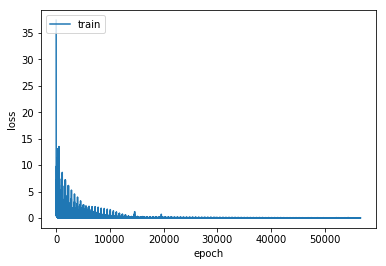

In [108]:
import matplotlib.pyplot as plt
import numpy
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [109]:
#saving the model after training
torch.save(model.state_dict(), 'model_0.pth')

In [110]:
model.eval()

# Sanity check for predictions after training
# No need to accumulate gradients because this is a validation
with torch.no_grad():
    precheck_sent = prepare_sequence(training_data[1][0], word_to_ix)
    precheck_sent = precheck_sent.to(device)
    pred =  model(precheck_sent)[1]
    print('Prediction:   ', [ix_to_tag[idx] for idx in pred])
    print('Ground truth: ', training_data[1][1])
    print(training_data[1][0])

Prediction:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Ground truth:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['rt', ':', 'delhi', 'diksha', 'bhati\nrequire', 'blood', 'b-ve', '\nsarka', 'vihar', 'aria\n', 'licomia\ncontact', 'manju.', '…']


# Evaluation

Let's test our model on an unseen sentence.

In [111]:
X_test = []
Y_test = []
for item in test_data:
    X_test.append(item[0])
    Y_test.append(item[1])

In [121]:
model.eval()
predicted = [] #labels
predictions = [] #numbers
for item in test_data:
    with torch.no_grad():
        test_datum = item[0]
        test_text = item[1]
        precheck_sent = prepare_sequence(test_datum, word_to_ix)
        precheck_sent = precheck_sent.to(device)
        pred = model(precheck_sent)[1]
        predictions.append(model(precheck_sent)[1])
        predicted.append([ix_to_tag[idx] for idx in pred])
        print('Prediction:   ', [ix_to_tag[idx] for idx in pred])
        print('Ground truth: ', test_text)
        print('Text: ', test_datum)

Prediction:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']
Ground truth:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O']
Text:  ['', 'hyderabad', '', 'units', 'o+ve', 'blood', 'urgent', 'need', 'by', '', 'am', 'july', 'at', 'star', 'hospital', 'banjara', 'hills', 'pls', 'call', 'bloodmatters']
Prediction:    ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Ground truth:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Text:  ['', 'chennai', 'o+ve', 'platelets', 'need', 'at', 'soundarapandian', 'bone', 'and', 'joint', 'hospital', 'anna', 'nagar', 'pls', 'call', 'july', 'via', 'bloodmatters']
Prediction:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']
Ground truth:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O']
Text:  ['', 'chennai', 'need', 'blood', 'platelets', 'b-ve', 'at

In [113]:
#Compute precision
def compute_precision(guessed_sentences, correct_sentences):
    assert (len(guessed_sentences) == len(correct_sentences))
    correctCount = 0
    count = 0

    for sentenceIdx in range(len(guessed_sentences)):
        guessed = guessed_sentences[sentenceIdx]
        correct = correct_sentences[sentenceIdx]
        assert (len(guessed) == len(correct))
        idx = 0
        while idx < len(guessed):
            if guessed[idx][0] == 'B':  # a new chunk starts
                count += 1

                if guessed[idx] == correct[idx]:  # first prediction correct
                    idx += 1
                    correctlyFound = True

                    while idx < len(guessed) and guessed[idx][0] == 'I':  # scan entire chunk
                        if guessed[idx] != correct[idx]:
                            correctlyFound = False 

                        idx += 1

                    if idx < len(guessed):
                        if correct[idx][0] == 'I':  # chunk in correct was longer
                            correctlyFound = False

                    if correctlyFound:
                        correctCount += 1
                else:
                    idx += 1
            else:
                idx += 1

    precision = 0
    if count > 0:
        precision = float(correctCount) / count

    return precision

In [114]:
import numpy as np


# Method to compute the accuracy. Call predict_labels to get the labels for the dataset
def compute_f1(predictions, correct, idx2Label):
    label_pred = []
    for sentence in predictions:
        label_pred.append([idx2Label[element] for element in sentence])

    label_correct = []
    for sentence in correct:
        label_correct.append(sentence)

    # print("predictions ", len(label_pred))
    # print("correct labels ", len(label_correct))

    prec = compute_precision(label_pred, label_correct)
    rec = compute_precision(label_correct, label_pred)

    f1 = 0
    if (rec + prec) > 0:
        f1 = 2.0 * prec * rec / (prec + rec);

    return prec, rec, f1

In [115]:
prec, rec, f1 = compute_f1(predictions, Y_test, ix_to_tag)

In [122]:
f1

0.8076923076923077

In [123]:
prec

0.84

In [124]:
rec

0.7777777777777778